In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr
import pickle
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua
import trajectory as trj

import h5py
import ray
import pyproj
# ray.init(num_cpus=7)


In [2]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

In [3]:
def get_cuon(stat, year):
    # stat = '11035'
    # year = '2000'
    dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

    conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/newindex/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    # conv_file = glob.glob('./0-20001-0-11035_CEUAS_merged_v1.nc')[0]

    df_dict = {}
    u_df_dict = {}
    v_df_dict = {}

    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]


    with h5py.File(conv_file, 'r') as file:
        rts = file['recordindices']['recordtimestamp'][:]
        idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
        if len(idx) == 0:
            print('(1) NO DATA FOUND IN CONVERTED_V9: ', sid)
        u_idx = file['recordindices']['139'][idx]
        v_idx = file['recordindices']['140'][idx]
        t_idx = file['recordindices']['126'][idx]
        
#         plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        
#         mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
#         mask = np.isin(mask,plevs)

#         u_mask = file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]]
#         u_mask = np.isin(u_mask,plevs)

#         v_mask = file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]]
#         v_mask = np.isin(v_mask,plevs)
        mask = len(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]])*[True]
        u_mask = len(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]])*[True]
        v_mask = len(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]])*[True]

        # t_len = len(mask[mask == True])
        # u_len = len(u_mask[u_mask == True])
        # v_len = len(v_mask[v_mask == True])
        
        t_len = len(mask)
        u_len = len(u_mask)
        v_len = len(v_mask)

        df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
        df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
        repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
        df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

        df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

        u_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['date_time'] = list(file['observations_table']['date_time'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['observation_value'] = list(file['observations_table']['observation_value'][u_idx[0]:u_idx[-1]][u_mask])

        v_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['date_time'] = list(file['observations_table']['date_time'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['observation_value'] = list(file['observations_table']['observation_value'][v_idx[0]:v_idx[-1]][v_mask])


        # df_dict['observation_value'] = ['air_temperature']*t_len
        # u_df_dict['observation_value'] = ['eastward_wind']*u_len
        # v_df_dict['observation_value'] = ['northward_wind']*v_len

        df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
        df = pd.DataFrame.from_dict(df_dict)
        df = df.rename(columns={'observation_value':'air_temperature'})

        u_df_dict['date_time'] = seconds_to_datetime(u_df_dict['date_time'])
        u_df = pd.DataFrame.from_dict(u_df_dict)
        u_df = u_df.rename(columns={'observation_value':'eastward_wind_speed'})

        v_df_dict['date_time'] = seconds_to_datetime(v_df_dict['date_time'])
        v_df = pd.DataFrame.from_dict(v_df_dict)
        v_df = v_df.rename(columns={'observation_value':'northward_wind_speed'})

        # put dfs together:
        df = df.merge(u_df, how='inner', on=['date_time','z_coordinate'])
        df = df.merge(v_df, how='inner', on=['date_time','z_coordinate'])
    #         print(df)
    return df

In [4]:
df = get_cuon('11035', '2000')
df

z_coordinate           date_time  air_temperature  latitude  longitude  \
0             590.0 2000-01-01 00:00:00       211.300003     48.23  16.370001   
1            1000.0 2000-01-01 00:00:00       205.899994     48.23  16.370001   
2            2000.0 2000-01-01 00:00:00       205.899994     48.23  16.370001   
3            3000.0 2000-01-01 00:00:00       206.300003     48.23  16.370001   
4            5000.0 2000-01-01 00:00:00       210.100006     48.23  16.370001   
...             ...                 ...              ...       ...        ...   
13794       50000.0 2000-12-30 12:00:00       245.899994     48.25  16.370001   
13795       70000.0 2000-12-30 12:00:00       258.299988     48.25  16.370001   
13796       85000.0 2000-12-30 12:00:00       267.500000     48.25  16.370001   
13797       92500.0 2000-12-30 12:00:00       270.700012     48.25  16.370001   
13798       97500.0 2000-12-30 12:00:00       274.200012     48.25  16.370001   

         report_id  RASE_bias_estimate  latitude_displacement  \
0      10000030635                 NaN                    NaN   
1      10000030635                 NaN                    NaN   
2      10000030635            0.131690              -0.841951   
3      10000030635            0.317648              -0.820070   
4      10000030635            0.350046              -0.783516   
...            ...                 ...                    ...   
13794  10000032094            0.032081              -0.023988   
13795  10000032094            0.006116              -0.032452   
13796  10000032094           -0.019600              -0.015018   
13797  10000032094           -0.000000              -0.003990   
13798  10000032094                 NaN               0.000000   

       longitude_displacement  time_since_launch  eastward_wind_speed  \
0                         NaN                NaN            55.000000   
1                         NaN                NaN            39.000000   
2                    0.079254        5119.552235            28.889647   
3                   -0.052334        4632.160858            21.612930   
4                   -0.163752        4009.962170            11.954336   
...                       ...                ...                  ...   
13794                0.160971        1015.058241             1.481648   
13795                0.070224         515.966123             7.456494   
13796                0.037043         217.175192            10.284602   
13797                0.012203          83.965126            12.990381   
13798                0.000000           0.000000             5.908846   

       northward_wind_speed  
0              1.010000e-14  
1              7.160000e-15  
2             -2.527517e+00  
3             -7.866463e+00  
4             -1.045869e+00  
...                     ...  
13794          1.693531e+01  
13795         -1.064898e+01  
13796         -1.225671e+01  
13797         -7.500000e+00  
13798         -1.041889e+00  

[13799 rows x 12 columns]

In [5]:
for i in list(df.report_id.unique()[100:102]):
    sub_df = df[df.report_id == i]
    sub_df = sub_df.iloc[::-1]
    if len(sub_df) > 3:
        sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
            lat=sub_df.latitude.iloc[0], lon=sub_df.longitude.iloc[0],
            temperature=np.array(sub_df.air_temperature), u=np.array(sub_df.eastward_wind_speed), v=np.array(sub_df.northward_wind_speed),
            pressure=np.array(sub_df.z_coordinate))
        ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
            lat=sub_df.latitude.iloc[0], lon=sub_df.longitude.iloc[0],
            temperature=np.array(sub_df.air_temperature), u=np.array(sub_df.eastward_wind_speed), v=np.array(sub_df.northward_wind_speed),
            pressure=np.array(sub_df.z_coordinate), transport_type='geod')
        sub_df['sph_lon_disp'] = sph_lon_disp
        sub_df['sph_lat_disp'] = sph_lat_disp
        sub_df['ell_lon_disp'] = ell_lon_disp
        sub_df['ell_lat_disp'] = ell_lat_disp
    display(sub_df[['z_coordinate','sph_lon_disp','ell_lon_disp', 'longitude_displacement','sph_lat_disp','ell_lat_disp', 'latitude_displacement']])

z_coordinate  sph_lon_disp  ell_lon_disp  longitude_displacement  \
1857       98800.0      0.000000      0.000000                     NaN   
1856       92500.0      0.008067      0.008043                0.001157   
1855       85000.0      0.020756      0.020694                0.008395   
1854       70000.0      0.049164      0.049017                0.042541   
1853       50000.0      0.085830      0.085574                0.108832   
1852       40000.0      0.124762      0.124390                0.175963   
1851       30000.0      0.193901      0.193323                0.292230   
1850       27800.0      0.209953      0.209327                0.319237   
1849       25000.0      0.233380      0.232685                0.344805   
1848       20000.0      0.279900      0.279067                0.381412   
1847       15000.0      0.325858      0.324888                0.452761   
1846       14100.0      0.335312      0.334315                0.469408   
1845       10000.0      0.393332      0.392163                0.552125   
1844        7000.0      0.466406      0.465021                0.627840   
1843        5000.0      0.546059      0.544438                0.687676   
1842        3000.0      0.680245      0.678227                0.818152   
1841        2000.0      0.801655      0.799279                0.942553   
1840        1000.0      1.036210      1.033140                1.157141   
1839         830.0      1.100830      1.097568                     NaN   

      sph_lat_disp  ell_lat_disp  latitude_displacement  
1857      0.000000      0.000000                    NaN  
1856     -0.001823     -0.001824               0.001772  
1855     -0.006281     -0.006282               0.006687  
1854     -0.022461     -0.022462               0.012525  
1853     -0.077651     -0.077652              -0.014646  
1852     -0.143656     -0.143659              -0.061183  
1851     -0.233497     -0.233502              -0.142970  
1850     -0.252096     -0.252102              -0.161732  
1849     -0.276607     -0.276615              -0.182539  
1848     -0.321095     -0.321104              -0.213447  
1847     -0.356673     -0.356685              -0.234693  
1846     -0.361538     -0.361550              -0.240525  
1845     -0.386236     -0.386249              -0.278944  
1844     -0.417923     -0.417938              -0.293157  
1843     -0.443255     -0.443273              -0.307033  
1842     -0.446018     -0.446035              -0.334582  
1841     -0.431703     -0.431719              -0.334168  
1840     -0.426104     -0.426119              -0.329305  
1839     -0.418472     -0.418486                    NaN

z_coordinate  sph_lon_disp  ell_lon_disp  longitude_displacement  \
1875       98100.0      0.000000      0.000000                     NaN   
1874       92500.0      0.001553      0.001548                0.002941   
1873       85000.0      0.010945      0.010912                0.022566   
1872       70000.0      0.069329      0.069121                0.073942   
1871       50000.0      0.187705      0.187145                0.175338   
1870       40000.0      0.249209      0.248465                0.265073   
1869       30000.0      0.340387      0.339372                0.359702   
1868       29400.0      0.347796      0.346759                0.365872   
1867       25000.0      0.397810      0.396624                0.420214   
1866       20000.0      0.465931      0.464543                0.490911   
1865       15000.0      0.549701      0.548064                0.584632   
1864       10000.0      0.633805      0.631918                0.702536   
1863        7000.0      0.714954      0.712826                0.814314   
1862        5000.0      0.797597      0.795224                0.865114   
1861        3000.0      0.913079      0.910363                0.993477   
1860        2000.0      1.018356      1.015328                1.083481   
1859        1000.0      1.220013      1.216387                1.284781   
1858         820.0      1.274951      1.271162                1.337291   

      sph_lat_disp  ell_lat_disp  latitude_displacement  
1875      0.000000      0.000000                    NaN  
1874      0.001247      0.001246              -0.000559  
1873      0.001871      0.001870              -0.004992  
1872     -0.010032     -0.010033              -0.017419  
1871     -0.042326     -0.042327              -0.040237  
1870     -0.063610     -0.063611              -0.056202  
1869     -0.094619     -0.094621              -0.071093  
1868     -0.097193     -0.097194              -0.072191  
1867     -0.116468     -0.116470              -0.082360  
1866     -0.139833     -0.139835              -0.101903  
1865     -0.177576     -0.177579              -0.139557  
1864     -0.219985     -0.219989              -0.178448  
1863     -0.248868     -0.248874              -0.201246  
1862     -0.275424     -0.275430              -0.210277  
1861     -0.299858     -0.299865              -0.243037  
1860     -0.304864     -0.304872              -0.252796  
1859     -0.274561     -0.274567              -0.205276  
1858     -0.267480     -0.267485              -0.179910

In [35]:
def get_cuon(stat, year):
    # stat = '11035'
    # year = '2000'
    dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

    # conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/newindex/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    conv_file = glob.glob('./*' + stat + '*_CEUAS_merged_v1.nc')[0]

    df_dict = {}
    u_df_dict = {}
    v_df_dict = {}

    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]


    with h5py.File(conv_file, 'r') as file:
        rts = file['recordindices']['recordtimestamp'][:]
        idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
        if len(idx) == 0:
            print('(1) NO DATA FOUND IN CONVERTED_V9: ', sid)
        u_idx = file['recordindices']['139'][idx]
        v_idx = file['recordindices']['140'][idx]
        t_idx = file['recordindices']['126'][idx]
        
#         plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        
#         mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
#         mask = np.isin(mask,plevs)

#         u_mask = file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]]
#         u_mask = np.isin(u_mask,plevs)

#         v_mask = file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]]
#         v_mask = np.isin(v_mask,plevs)
        mask = len(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]])*[True]
        u_mask = len(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]])*[True]
        v_mask = len(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]])*[True]

        # t_len = len(mask[mask == True])
        # u_len = len(u_mask[u_mask == True])
        # v_len = len(v_mask[v_mask == True])
        
        t_len = len(mask)
        u_len = len(u_mask)
        v_len = len(v_mask)

        df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
        df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
        repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
        df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

        # df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude_displacement'] = list(file['new_2_advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude_displacement'] = list(file['new_2_advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['time_since_launch'] = list(file['new_2_advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

        u_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['date_time'] = list(file['observations_table']['date_time'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['observation_value'] = list(file['observations_table']['observation_value'][u_idx[0]:u_idx[-1]][u_mask])

        v_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['date_time'] = list(file['observations_table']['date_time'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['observation_value'] = list(file['observations_table']['observation_value'][v_idx[0]:v_idx[-1]][v_mask])


        # df_dict['observation_value'] = ['air_temperature']*t_len
        # u_df_dict['observation_value'] = ['eastward_wind']*u_len
        # v_df_dict['observation_value'] = ['northward_wind']*v_len

        df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
        df = pd.DataFrame.from_dict(df_dict)
        df = df.rename(columns={'observation_value':'air_temperature'})

        u_df_dict['date_time'] = seconds_to_datetime(u_df_dict['date_time'])
        u_df = pd.DataFrame.from_dict(u_df_dict)
        u_df = u_df.rename(columns={'observation_value':'eastward_wind_speed'})

        v_df_dict['date_time'] = seconds_to_datetime(v_df_dict['date_time'])
        v_df = pd.DataFrame.from_dict(v_df_dict)
        v_df = v_df.rename(columns={'observation_value':'northward_wind_speed'})

        # put dfs together:
        df = df.merge(u_df, how='inner', on=['date_time','z_coordinate'])
        df = df.merge(v_df, how='inner', on=['date_time','z_coordinate'])
    #         print(df)
    return df

In [36]:
df = get_cuon('11035', '2000')
df

z_coordinate           date_time  air_temperature  latitude  longitude  \
0             590.0 2000-01-01 00:00:00       211.300003     48.23  16.370001   
1            1000.0 2000-01-01 00:00:00       205.899994     48.23  16.370001   
2            2000.0 2000-01-01 00:00:00       205.899994     48.23  16.370001   
3            3000.0 2000-01-01 00:00:00       206.300003     48.23  16.370001   
4            5000.0 2000-01-01 00:00:00       210.100006     48.23  16.370001   
...             ...                 ...              ...       ...        ...   
13794       50000.0 2000-12-30 12:00:00       245.899994     48.25  16.370001   
13795       70000.0 2000-12-30 12:00:00       258.299988     48.25  16.370001   
13796       85000.0 2000-12-30 12:00:00       267.500000     48.25  16.370001   
13797       92500.0 2000-12-30 12:00:00       270.700012     48.25  16.370001   
13798       97500.0 2000-12-30 12:00:00       274.200012     48.25  16.370001   

         report_id  latitude_displacement  longitude_displacement  \
0      10000030635              -0.537016                1.185215   
1      10000030635              -0.525792                0.751548   
2      10000030635              -0.507910                0.352503   
3      10000030635              -0.486884                0.191194   
4      10000030635              -0.468999                0.058766   
...            ...                    ...                     ...   
13794  10000032094              -0.008377                0.089127   
13795  10000032094              -0.046332                0.068438   
13796  10000032094              -0.015552                0.032604   
13797  10000032094              -0.003226                0.010731   
13798  10000032094               0.000000                0.000000   

       time_since_launch  eastward_wind_speed  northward_wind_speed  
0            6591.486120            55.000000          1.010000e-14  
1            5950.566112            39.000000          7.160000e-15  
2            5119.552235            28.889647         -2.527517e+00  
3            4632.160858            21.612930         -7.866463e+00  
4            4009.962170            11.954336         -1.045869e+00  
...                  ...                  ...                   ...  
13794        1015.058241             1.481648          1.693531e+01  
13795         515.966123             7.456494         -1.064898e+01  
13796         217.175192            10.284602         -1.225671e+01  
13797          83.965126            12.990381         -7.500000e+00  
13798           0.000000             5.908846         -1.041889e+00  

[13799 rows x 11 columns]

In [37]:
for i in list(df.report_id.unique()[100:102]):
    sub_df = df[df.report_id == i]
    sub_df = sub_df.iloc[::-1]
    if len(sub_df) > 3:
        sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
            lat=sub_df.latitude.iloc[0], lon=sub_df.longitude.iloc[0],
            temperature=np.array(sub_df.air_temperature), u=np.array(sub_df.eastward_wind_speed), v=np.array(sub_df.northward_wind_speed),
            pressure=np.array(sub_df.z_coordinate))
        ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
            lat=sub_df.latitude.iloc[0], lon=sub_df.longitude.iloc[0],
            temperature=np.array(sub_df.air_temperature), u=np.array(sub_df.eastward_wind_speed), v=np.array(sub_df.northward_wind_speed),
            pressure=np.array(sub_df.z_coordinate), transport_type='geod')
        sub_df['sph_lon_disp'] = sph_lon_disp
        sub_df['sph_lat_disp'] = sph_lat_disp
        sub_df['ell_lon_disp'] = ell_lon_disp
        sub_df['ell_lat_disp'] = ell_lat_disp
    display(sub_df[['report_id','z_coordinate','sph_lon_disp','ell_lon_disp', 'longitude_displacement','sph_lat_disp','ell_lat_disp', 'latitude_displacement']])

report_id  z_coordinate  sph_lon_disp  ell_lon_disp  \
1857  10000030830       98800.0      0.000000      0.000000   
1856  10000030830       92500.0      0.008067      0.008043   
1855  10000030830       85000.0      0.020756      0.020694   
1854  10000030830       70000.0      0.049164      0.049017   
1853  10000030830       50000.0      0.085830      0.085574   
1852  10000030830       40000.0      0.124762      0.124390   
1851  10000030830       30000.0      0.193901      0.193323   
1850  10000030830       27800.0      0.209953      0.209327   
1849  10000030830       25000.0      0.233380      0.232685   
1848  10000030830       20000.0      0.279900      0.279067   
1847  10000030830       15000.0      0.325858      0.324888   
1846  10000030830       14100.0      0.335312      0.334315   
1845  10000030830       10000.0      0.393332      0.392163   
1844  10000030830        7000.0      0.466406      0.465021   
1843  10000030830        5000.0      0.546059      0.544438   
1842  10000030830        3000.0      0.680245      0.678227   
1841  10000030830        2000.0      0.801655      0.799279   
1840  10000030830        1000.0      1.036210      1.033140   
1839  10000030830         830.0      1.100830      1.097568   

      longitude_displacement  sph_lat_disp  ell_lat_disp  \
1857                0.000000      0.000000      0.000000   
1856                0.008062     -0.001823     -0.001824   
1855                0.021293     -0.006281     -0.006282   
1854                0.047808     -0.022461     -0.022462   
1853                0.078753     -0.077651     -0.077652   
1852                0.121447     -0.143656     -0.143659   
1851                0.191603     -0.233497     -0.233502   
1850                0.207646     -0.252096     -0.252102   
1849                0.231099     -0.276607     -0.276615   
1848                0.283539     -0.321095     -0.321104   
1847                0.332735     -0.356673     -0.356685   
1846                0.342198     -0.361538     -0.361550   
1845                0.400498     -0.386236     -0.386249   
1844                0.484302     -0.417923     -0.417938   
1843                0.556923     -0.443255     -0.443273   
1842                0.690887     -0.446018     -0.446035   
1841                0.803705     -0.431703     -0.431719   
1840                1.011205     -0.426104     -0.426119   
1839                1.075996     -0.418472     -0.418486   

      latitude_displacement  
1857               0.000000  
1856              -0.001822  
1855              -0.006653  
1854              -0.024018  
1853              -0.083830  
1852              -0.157493  
1851              -0.248923  
1850              -0.267493  
1849              -0.292005  
1848              -0.338039  
1847              -0.379013  
1846              -0.383878  
1845              -0.411063  
1844              -0.440217  
1843              -0.437435  
1842              -0.443909  
1841              -0.431520  
1840              -0.399105  
1839              -0.396047

report_id  z_coordinate  sph_lon_disp  ell_lon_disp  \
1875  10000030832       98100.0      0.000000      0.000000   
1874  10000030832       92500.0      0.001553      0.001548   
1873  10000030832       85000.0      0.010945      0.010912   
1872  10000030832       70000.0      0.069329      0.069121   
1871  10000030832       50000.0      0.187705      0.187145   
1870  10000030832       40000.0      0.249209      0.248465   
1869  10000030832       30000.0      0.340387      0.339372   
1868  10000030832       29400.0      0.347796      0.346759   
1867  10000030832       25000.0      0.397810      0.396624   
1866  10000030832       20000.0      0.465931      0.464543   
1865  10000030832       15000.0      0.549701      0.548064   
1864  10000030832       10000.0      0.633805      0.631918   
1863  10000030832        7000.0      0.714954      0.712826   
1862  10000030832        5000.0      0.797597      0.795224   
1861  10000030832        3000.0      0.913079      0.910363   
1860  10000030832        2000.0      1.018356      1.015328   
1859  10000030832        1000.0      1.220013      1.216387   
1858  10000030832         820.0      1.274951      1.271162   

      longitude_displacement  sph_lat_disp  ell_lat_disp  \
1875                0.000000      0.000000      0.000000   
1874                0.001031      0.001247      0.001246   
1873                0.009710      0.001871      0.001870   
1872                0.069771     -0.010032     -0.010033   
1871                0.188185     -0.042326     -0.042327   
1870                0.249619     -0.063610     -0.063611   
1869                0.341822     -0.094619     -0.094621   
1868                0.349240     -0.097193     -0.097194   
1867                0.400253     -0.116468     -0.116470   
1866                0.468898     -0.139833     -0.139835   
1865                0.552263     -0.177576     -0.177579   
1864                0.636473     -0.219985     -0.219989   
1863                0.732431     -0.248868     -0.248874   
1862                0.802151     -0.275424     -0.275430   
1861                0.918259     -0.299858     -0.299865   
1860                1.022343     -0.304864     -0.304872   
1859                1.199349     -0.274561     -0.274567   
1858                1.261886     -0.267480     -0.267485   

      latitude_displacement  
1875               0.000000  
1874               0.001175  
1873               0.002380  
1872              -0.013412  
1871              -0.044927  
1870              -0.066211  
1869              -0.098618  
1868              -0.101191  
1867              -0.121740  
1866              -0.145034  
1865              -0.183097  
1864              -0.225506  
1863              -0.254839  
1862              -0.280608  
1861              -0.292441  
1860              -0.296346  
1859              -0.252045  
1858              -0.246224

In [50]:
def get_t_only_cuon(stat, year):
    # stat = '11035'
    # year = '2000'
    dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

    # conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/newindex/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    conv_file = glob.glob('./*' + stat + '*_CEUAS_merged_v1.nc')[0]

    df_dict = {}
    u_df_dict = {}
    v_df_dict = {}

    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]


    with h5py.File(conv_file, 'r') as file:
        rts = file['recordindices']['recordtimestamp'][:]
        idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
        if len(idx) == 0:
            print('(1) NO DATA FOUND IN CONVERTED_V9: ', sid)
        u_idx = file['recordindices']['139'][idx]
        v_idx = file['recordindices']['140'][idx]
        t_idx = file['recordindices']['126'][idx]
        
#         plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        
#         mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
#         mask = np.isin(mask,plevs)

#         u_mask = file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]]
#         u_mask = np.isin(u_mask,plevs)

#         v_mask = file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]]
#         v_mask = np.isin(v_mask,plevs)
        mask = len(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]])*[True]
        u_mask = len(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]])*[True]
        v_mask = len(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]])*[True]

        # t_len = len(mask[mask == True])
        # u_len = len(u_mask[u_mask == True])
        # v_len = len(v_mask[v_mask == True])
        
        t_len = len(mask)
        u_len = len(u_mask)
        v_len = len(v_mask)

        df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
        df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
        repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
        df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

        # df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude_displacement'] = list(file['new_2_advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude_displacement'] = list(file['new_2_advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['time_since_launch'] = list(file['new_2_advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

        u_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['date_time'] = list(file['observations_table']['date_time'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['observation_value'] = list(file['observations_table']['observation_value'][u_idx[0]:u_idx[-1]][u_mask])
        repid = np.asarray(file['observations_table']['report_id'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

#         v_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]][v_mask])
#         v_df_dict['date_time'] = list(file['observations_table']['date_time'][v_idx[0]:v_idx[-1]][v_mask])
#         v_df_dict['observation_value'] = list(file['observations_table']['observation_value'][v_idx[0]:v_idx[-1]][v_mask])


        df_dict['observation_value'] = ['air_temperature']*t_len
        u_df_dict['observation_value'] = ['eastward_wind']*u_len
        # v_df_dict['observation_value'] = ['northward_wind']*v_len

        df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
        df = pd.DataFrame.from_dict(df_dict)
        df = df.rename(columns={'observation_value':'air_temperature'})

        u_df_dict['date_time'] = seconds_to_datetime(u_df_dict['date_time'])
        u_df = pd.DataFrame.from_dict(u_df_dict)
        u_df = u_df.rename(columns={'observation_value':'eastward_wind_speed'})

#         v_df_dict['date_time'] = seconds_to_datetime(v_df_dict['date_time'])
#         v_df = pd.DataFrame.from_dict(v_df_dict)
#         v_df = v_df.rename(columns={'observation_value':'northward_wind_speed'})

        # put dfs together:
        # df = df.merge(u_df, how='inner', on=['date_time','z_coordinate'])
        # df = df.merge(v_df, how='inner', on=['date_time','z_coordinate'])
    #         print(df)
    return df, u_df

In [51]:
df, u_df= get_t_only_cuon('11035', '2000')
df[df.report_id == '10000030830']

z_coordinate           date_time  air_temperature  latitude  longitude  \
6180         830.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   
6181         910.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   
6182        1000.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   
6183        1070.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   
6184        1170.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   
...            ...                 ...              ...       ...        ...   
6247       85000.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   
6248       88000.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   
6249       92500.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   
6250       98100.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   
6251       98800.0 2000-02-18 12:00:00  air_temperature     48.25  16.370001   

        report_id  latitude_displacement  longitude_displacement  \
6180  10000030830              -0.396047                1.075996   
6181  10000030830              -0.400480                1.044627   
6182  10000030830              -0.399105                1.011205   
6183  10000030830              -0.398488                0.987691   
6184  10000030830              -0.400248                0.959197   
...           ...                    ...                     ...   
6247  10000030830              -0.006653                0.021293   
6248  10000030830              -0.004462                0.015587   
6249  10000030830              -0.001822                0.008062   
6250  10000030830              -0.000102                0.000781   
6251  10000030830               0.000000                0.000000   

      time_since_launch  
6180        6320.165726  
6181        6199.981386  
6182        6077.855196  
6183        5991.508758  
6184        5878.373351  
...                 ...  
6247         238.616186  
6248         184.481184  
6249         105.769443  
6250          11.538444  
6251           0.000000  

[72 rows x 9 columns]

In [53]:
u_df[u_df.report_id == '10000030830']

50

In [47]:
df

z_coordinate           date_time  air_temperature  latitude  longitude  \
0             590.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
1             760.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
2            1000.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
3            1190.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
4            1320.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
...             ...                 ...              ...       ...        ...   
45858       85000.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   
45859       90700.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   
45860       91300.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   
45861       92500.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   
45862       97500.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   

         report_id  latitude_displacement  longitude_displacement  \
0      10000030635              -0.537016                1.185215   
1      10000030635              -0.531568                0.958580   
2      10000030635              -0.525792                0.751548   
3      10000030635              -0.522983                0.639728   
4      10000030635              -0.519077                0.574202   
...            ...                    ...                     ...   
45858  10000032094              -0.015552                0.032604   
45859  10000032094              -0.005592                0.016269   
45860  10000032094              -0.004738                0.014395   
45861  10000032094              -0.003226                0.010731   
45862  10000032094               0.000000                0.000000   

       time_since_launch  
0            6591.486120  
1            6281.851677  
2            5950.566112  
3            5741.417399  
4            5617.479031  
...                  ...  
45858         217.175192  
45859         115.038310  
45860         104.620234  
45861          83.965126  
45862           0.000000  

[45863 rows x 9 columns]

In [101]:
print(trj.trajectory(lat=0,lon=0,u=[10,10,10],v=[0,0,0],pressure=[100000,85000,70000],temperature=[270,270,270])[:2])
print(trj.trajectory(lat=0,lon=0,u=[0,0,0],v=[10,10,10],pressure=[100000,85000,70000],temperature=[270,270,270])[:2])


([0.0, 1.4112449796858774e-18, 3.0964329202738115e-18], [0.0, 0.0230473801707841, 0.05056859150071121])
([0.0, 0.023047380170784098, 0.05056859150071121], [0.0, 0.0, 0.0])


In [33]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    
    rmse_total_lat = []
    rmse_total_lon = []
    rmse_total_lat_1 = []
    rmse_total_lon_1 = []
    
    rmse_sum_lon_1={}
    rmse_sum_lat_1={}
    rmse_sum_lon_2={}
    rmse_sum_lat_2={}
    rms_sum_lon_0={}
    rms_sum_lat_0={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        rmse_sum_lon_1[i] = []
        rmse_sum_lat_1[i] = []
        rmse_sum_lon_2[i] = []
        rmse_sum_lat_2[i] = []
        rms_sum_lon_0[i] = []
        rms_sum_lat_0[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]
        
            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))
            
            reduced_out = out[np.isin(out.pressure, stdplevs)]

            sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='sphere')
            
            reduced_sph_lat_disp, reduced_sph_lon_disp, dummy, dummy, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='sphere')
            
            ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='geod')
            
            reduced_ell_lat_disp, reduced_ell_lon_disp, dummy, dummy, reduced_ell_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='geod')


            fig, ax1 = maplt.subplots(figsize=(15, 9))
            ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
            ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')
            
            ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
            ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')
            
            ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
            ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')
            
            ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
            ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')
            
            #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
            #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
            ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
            ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

            ax1.set_ylabel('pressure (Pa)')
            ax1.set_xlabel('displacement (°)')
            ax1.tick_params(axis='x')
            ax1.set_ylim(ax1.get_ylim()[::-1])
            ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

            ax1_2 = ax1.twiny()
            ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
            ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            maplt.title('different displacements')
            maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
            maplt.grid()
            maplt.show()
            maplt.close()
            pltcount += 1
        # if pltcount > 10:
        #     break
    return out

In [15]:
# ipath=os.path.expanduser('~leo/ectrans/')
# sodblist=glob.glob(ipath+'era5.bufr.202006')
# sodblist.sort(key=os.path.getsize)
# out = par_read_bufr_stn_nofeedback(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [18]:
def par_read_bufr_stn_nofeedback_rmse(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue

            sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='sphere')

            reduced_sph_lat_disp, reduced_sph_lon_disp, dummy, dummy, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='sphere')

            ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='geod')

            reduced_ell_lat_disp, reduced_ell_lon_disp, dummy, dummy, reduced_ell_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='geod')

            for i in stdplevs:
                try:
                    rmse_sum_lon_s[i].append(
                        float(np.array(sph_lon_disp)[out.pressure == i] - 
                              out[out.pressure == i].longitudeDisplacement.values)
                        # / (float(out[out.pressure == i].longitudeDisplacement.values))
                    )
                    rmse_sum_lat_s[i].append(
                        float(np.array(sph_lat_disp)[out.pressure == i] - 
                              out[out.pressure == i].latitudeDisplacement.values) 
                        # / (float(out[out.pressure == i].latitudeDisplacement.values))
                    )
                    rmse_sum_lon_sr[i].append(
                        float(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
                        # / (float(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    )
                    rmse_sum_lat_sr[i].append(
                        float(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
                        # / (float(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    )
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    rmse_sum_lon_sr[i].append(np.nan)
                    rmse_sum_lat_sr[i].append(np.nan)
                    plev_vals[i].append(0)
                    

#             fig, ax1 = maplt.subplots(figsize=(15, 9))
#             ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
#             ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')

#             ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
#             ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

#             ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
#             ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')

#             ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
#             ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

#             #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#             #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
#             ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
#             ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

#             ax1.set_ylabel('pressure (Pa)')
#             ax1.set_xlabel('displacement (°)')
#             ax1.tick_params(axis='x')
#             ax1.set_ylim(ax1.get_ylim()[::-1])
#             ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

#             ax1_2 = ax1.twiny()
#             ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
#             ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

#             fig.tight_layout()  # otherwise the right y-label is slightly clipped
#             maplt.title('different displacements')
#             maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
#             maplt.grid()
#             maplt.show()
#             maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            if pltcount > 100:
                break
    
    limit = [5,95]
    for i in stdplevs:
        
        rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
        rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
        rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
        rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
    
    rmse_lat_s = []
    rmse_lon_s = []
    rmse_lat_sr = []
    rmse_lon_sr = []
    for i in stdplevs:
        rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
        rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
        rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
        rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        
        # rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
        # rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
        # rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
        # rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        
    fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
    ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat RMSE spher disp')
    ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat RMSE reduced spher disp')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('RMSE of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    
    ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon RMSE spher disp')
    ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon RMSE reduced spher disp')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('RMSE of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    value_nr = []
    for i in plev_vals:
        value_nr.append(np.sum(plev_vals[i]))
    ax1[2].barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
    ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    ax1[2].set_xlabel('Number of Values')
    ax1[2].tick_params(labelleft=False)
    ax1[2].grid()
    
    maplt.title('LEVEL RMSE for Displacement')
    maplt.show()
    maplt.close()
    
    return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>


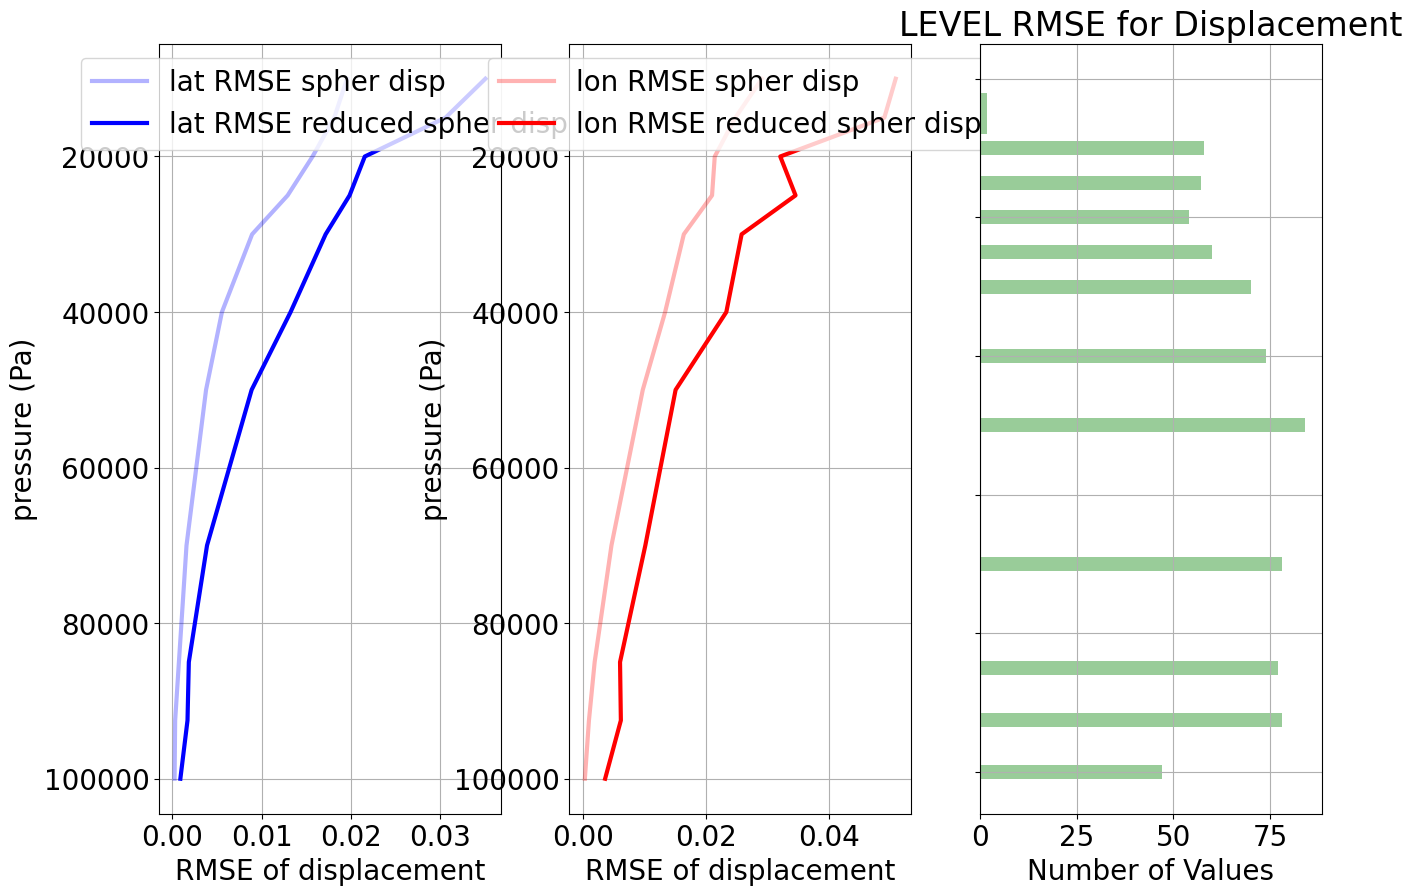

In [19]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_rmse(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [93]:
def par_read_bufr_stn_nofeedback_mean_relative_error(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue
            if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001):
                continue
                
            sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='sphere')

            reduced_sph_lat_disp, reduced_sph_lon_disp, dummy, dummy, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='sphere')

            ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='geod')

            reduced_ell_lat_disp, reduced_ell_lon_disp, dummy, dummy, reduced_ell_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='geod')

            for i in stdplevs:
                try:
                    rmse_sum_lon_s[i].append(
                        np.abs(np.array(sph_lon_disp)[out.pressure == i] - 
                              out[out.pressure == i].longitudeDisplacement.values)
                        / np.abs(float(out[out.pressure == i].longitudeDisplacement.values))
                    )
                    rmse_sum_lat_s[i].append(
                        np.abs(np.array(sph_lat_disp)[out.pressure == i] - 
                              out[out.pressure == i].latitudeDisplacement.values) 
                        / np.abs(float(out[out.pressure == i].latitudeDisplacement.values))
                    )
                    rmse_sum_lon_sr[i].append(
                        np.abs(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
                        / np.abs(float(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    )
                    rmse_sum_lat_sr[i].append(
                        np.abs(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
                        / np.abs(float(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    )
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    rmse_sum_lon_sr[i].append(np.nan)
                    rmse_sum_lat_sr[i].append(np.nan)
                    plev_vals[i].append(0)
                    

#             fig, ax1 = maplt.subplots(figsize=(15, 9))
#             ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
#             ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')

#             ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
#             ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

#             ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
#             ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')

#             ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
#             ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

#             #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#             #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
#             ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
#             ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

#             ax1.set_ylabel('pressure (Pa)')
#             ax1.set_xlabel('displacement (°)')
#             ax1.tick_params(axis='x')
#             ax1.set_ylim(ax1.get_ylim()[::-1])
#             ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

#             ax1_2 = ax1.twiny()
#             ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
#             ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

#             fig.tight_layout()  # otherwise the right y-label is slightly clipped
#             maplt.title('different displacements')
#             maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
#             maplt.grid()
#             maplt.show()
#             maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            if pltcount > 100:
                break
    
    limit = [0,95]
    for i in stdplevs:
        
        rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
        rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
        rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
        rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
    
    rmse_lat_s = []
    rmse_lon_s = []
    rmse_lat_sr = []
    rmse_lon_sr = []
    for i in stdplevs:
        # rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
        # rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
        # rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
        # rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        
        rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
        rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
        rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
        rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        
    fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
    ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat MRE spher disp')
    ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat MRE reduced spher disp')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('Mean relative error of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    
    ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon MRE spher disp')
    ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon MRE reduced spher disp')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('Mean relative error of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    value_nr = []
    for i in plev_vals:
        value_nr.append(np.sum(plev_vals[i]))
    ax1[2].barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
    ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    ax1[2].set_xlabel('Number of Values')
    ax1[2].tick_params(labelleft=False)
    ax1[2].grid()
    
    maplt.title('LEVEL MRE for Displacement')
    maplt.show()
    maplt.close()
    
    return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>


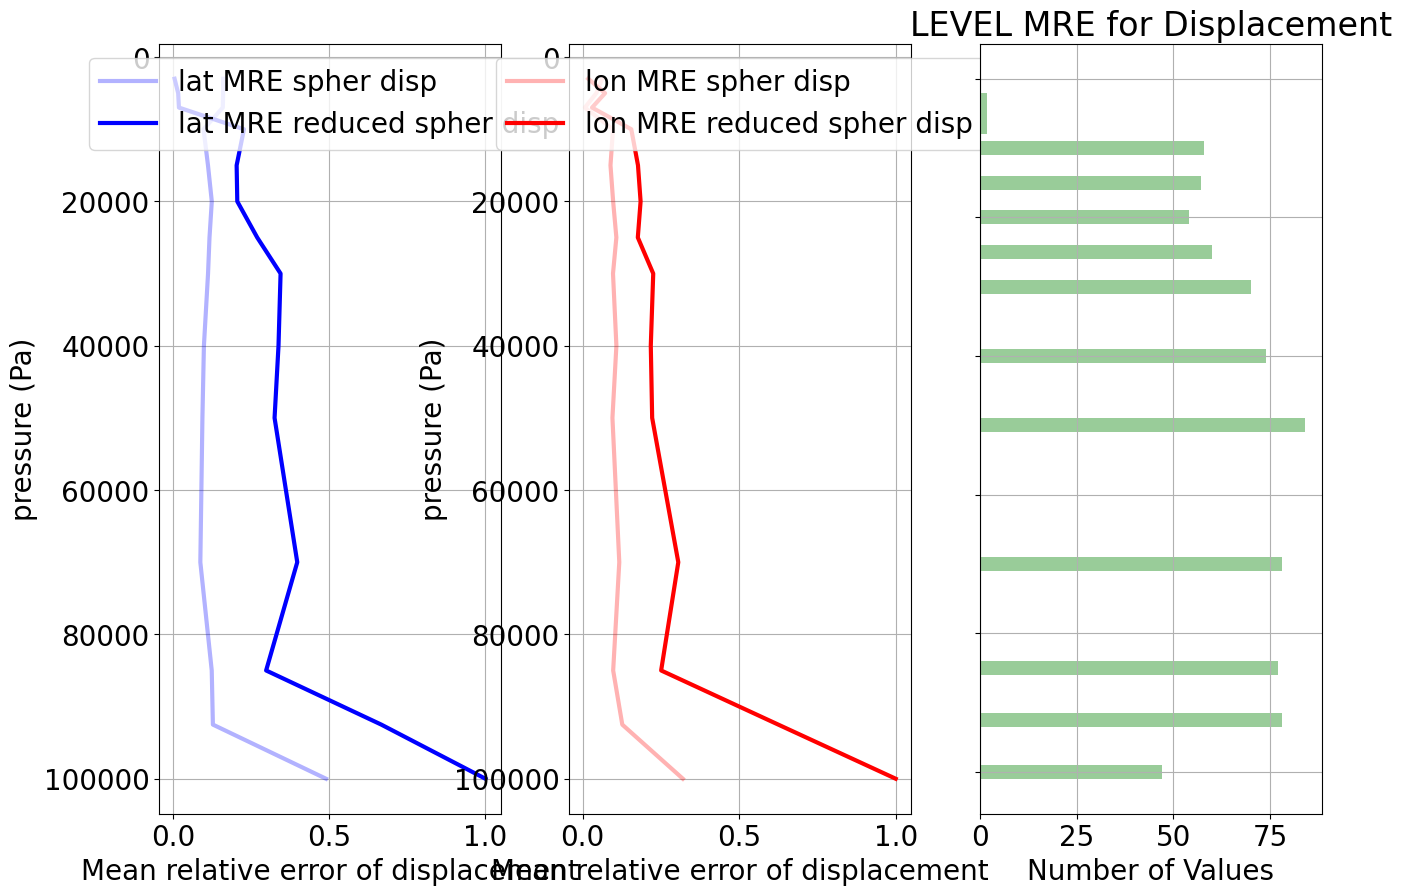

In [94]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mean_relative_error(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [8]:
def par_read_bufr_stn_nofeedback_rmse_interp(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}
    rmse_sum_lon_sri={}
    rmse_sum_lat_sri={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []
        rmse_sum_lon_sri[i] = []
        rmse_sum_lat_sri[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            if len(reduced_out) < 5:
                continue
                
            if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
                continue
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue
                
            num_p = 20
            p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
            true_p_list = list(reduced_out.pressure)
            for i in p_list:
                true_p_list.append(find_nearest(out.pressure, i))
            interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
            # display(interpolated_reduced_out)
            # display(reduced_out)
            u_new = []
            v_new = []
            # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
            # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
            # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
            # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
            for k in range(len(interpolated_reduced_out)):
                if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
                    u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
                    v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
                else:
                    u_new.append(np.nan)
                    v_new.append(np.nan)

            u = np.array(u_new)
            v = np.array(v_new)
            interpolated_reduced_out['ip_u'] = u
            interpolated_reduced_out['ip_v'] = v
            interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
            reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
                pressure=np.array(interpolated_reduced_out.pressure),
                transport_type='sphere')
            
            # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

            sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='sphere')

            reduced_sph_lat_disp, reduced_sph_lon_disp, dummy, dummy, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='sphere')

            ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='geod')

            reduced_ell_lat_disp, reduced_ell_lon_disp, dummy, dummy, reduced_ell_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='geod')
            

            for i in stdplevs:
                try:
                    rmse_sum_lon_s[i].append(
                        float(np.array(sph_lon_disp)[out.pressure == i] - 
                              out[out.pressure == i].longitudeDisplacement.values)
                        # / (float(out[out.pressure == i].longitudeDisplacement.values))
                    )
                    rmse_sum_lat_s[i].append(
                        float(np.array(sph_lat_disp)[out.pressure == i] - 
                              out[out.pressure == i].latitudeDisplacement.values) 
                        # / (float(out[out.pressure == i].latitudeDisplacement.values))
                    )
                    rmse_sum_lon_sr[i].append(
                        float(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
                        # / (float(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    )
                    rmse_sum_lat_sr[i].append(
                        float(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
                        # / (float(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    )
                    rmse_sum_lon_sri[i].append(
                        float(np.array(reduced_interp_sph_lon_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].longitudeDisplacement.values) 
                        # / (float(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    )
                    rmse_sum_lat_sri[i].append(
                        float(np.array(reduced_interp_sph_lat_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].latitudeDisplacement.values) 
                        # / (float(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    )
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    rmse_sum_lon_sr[i].append(np.nan)
                    rmse_sum_lat_sr[i].append(np.nan)
                    rmse_sum_lon_sri[i].append(np.nan)
                    rmse_sum_lat_sri[i].append(np.nan)
                    plev_vals[i].append(0)
                    
            if (pltcount % 20) == 0:
                print('length of input data:',len(out))
                print('significant levels:',len(reduced_out))
                # display(interpolated_reduced_out)
                fig, ax1 = maplt.subplots(figsize=(15, 9))
                ax1.plot(np.array(reduced_interp_sph_lat_disp), interpolated_reduced_out.pressure, color = 'green', alpha = 1, linewidth= 1, label='ri sphere calc lat disp')
                ax1.plot(np.array(reduced_interp_sph_lon_disp), interpolated_reduced_out.pressure, color = 'brown', alpha = 1, linewidth= 1, label='ri sphere calc lon disp')

                ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
                ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')

                ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
                ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

                ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
                ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')

                ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
                ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

                #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
                #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
                ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

                ax1.set_ylabel('pressure (Pa)')
                ax1.set_xlabel('displacement (°)')
                ax1.tick_params(axis='x')
                ax1.set_ylim(ax1.get_ylim()[::-1])
                ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

                ax1_2 = ax1.twiny()
                ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
                ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('different displacements')
                maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
                maplt.grid()
                maplt.show()
                maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            # break
            if pltcount > 100:
                break
    
    limit = [5,95]
    for i in stdplevs:
        
        rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
        rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
        rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
        rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        rmse_sum_lat_sri[i] = np.array(rmse_sum_lat_sri[i])
        rmse_sum_lon_sri[i] = np.array(rmse_sum_lon_sri[i])
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sri[i], limit)
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sri[i], limit)
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] > outlier_drop[1]] = np.nan
    
    rmse_lat_s = []
    rmse_lon_s = []
    rmse_lat_sr = []
    rmse_lon_sr = []
    rmse_lat_sri = []
    rmse_lon_sri = []
    for i in stdplevs:
        rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
        rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
        rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
        rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        rmse_lat_sri.append(np.sqrt(np.nanmean((rmse_sum_lat_sri[i])**2)))
        rmse_lon_sri.append(np.sqrt(np.nanmean((rmse_sum_lon_sri[i])**2)))
        
        # rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
        # rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
        # rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
        # rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        
    # print(rmse_sum_lon_sri)
    # print(rmse_sum_lon_sr)
    fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
    ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat RMSE spher disp')
    ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat RMSE reduced spher disp')
    ax1[0].plot(np.array(rmse_lat_sri), stdplevs, color = 'green', label = 'lat RMSE reduced interp spher disp')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('RMSE of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    
    ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon RMSE spher disp')
    ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon RMSE reduced spher disp')
    ax1[1].plot(np.array(rmse_lon_sri), stdplevs, color = 'orange', label = 'lon RMSE reduced interp spher disp')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('RMSE of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    value_nr = []
    for i in plev_vals:
        value_nr.append(np.sum(plev_vals[i]))
    ax1[2].barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
    ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    ax1[2].set_xlabel('Number of Values')
    ax1[2].tick_params(labelleft=False)
    ax1[2].grid()
    
    maplt.title('LEVEL RMSE for Displacement')
    maplt.show()
    maplt.close()
    
    return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>
length of input data: 931
significant levels: 5


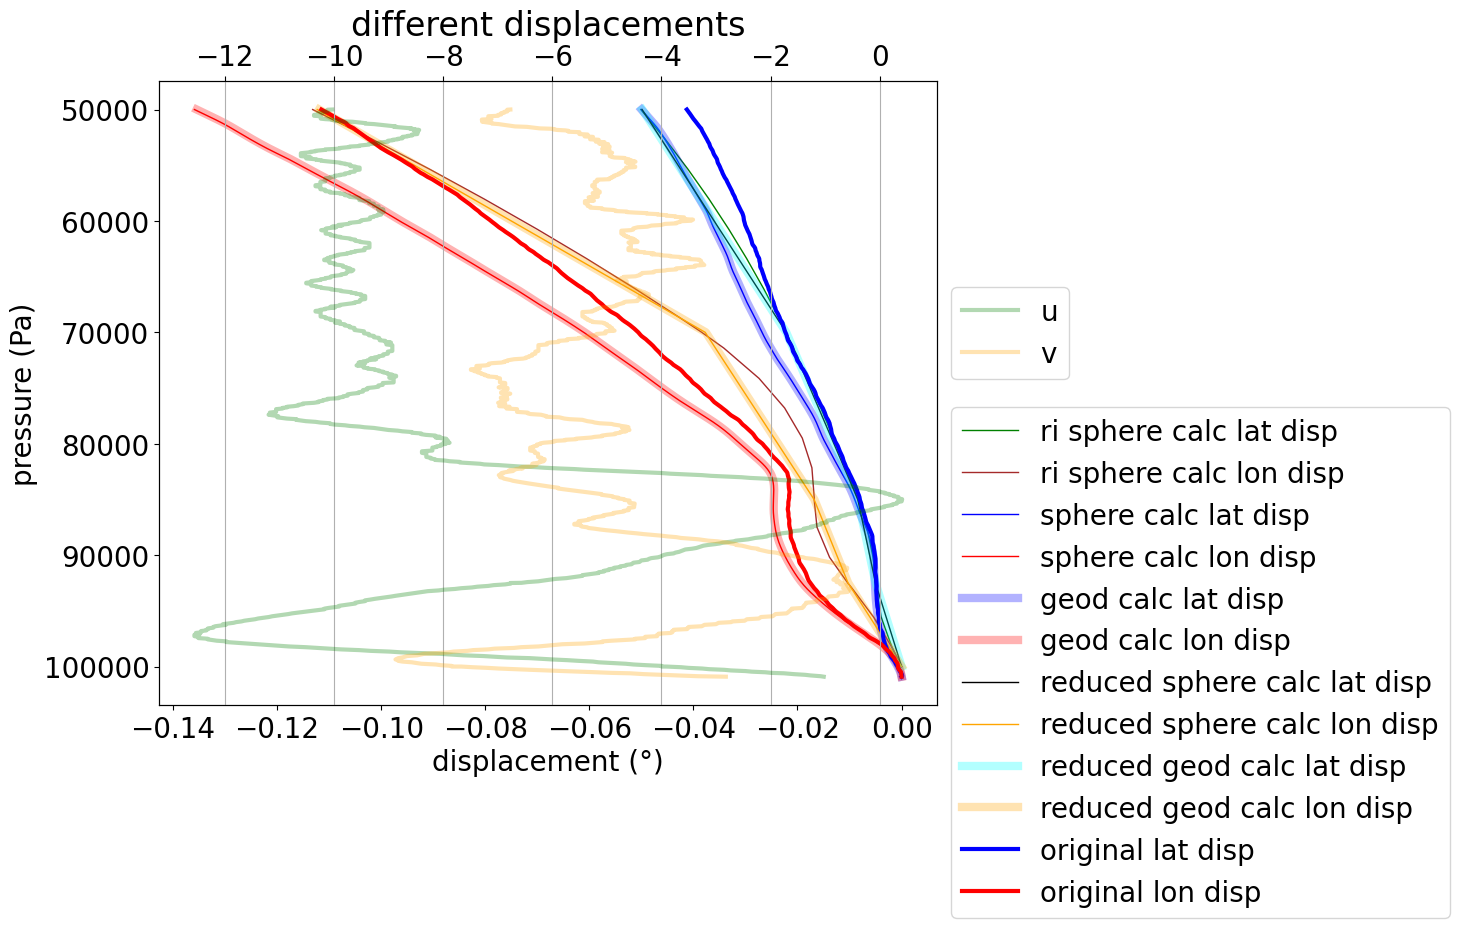

length of input data: 1440
significant levels: 10


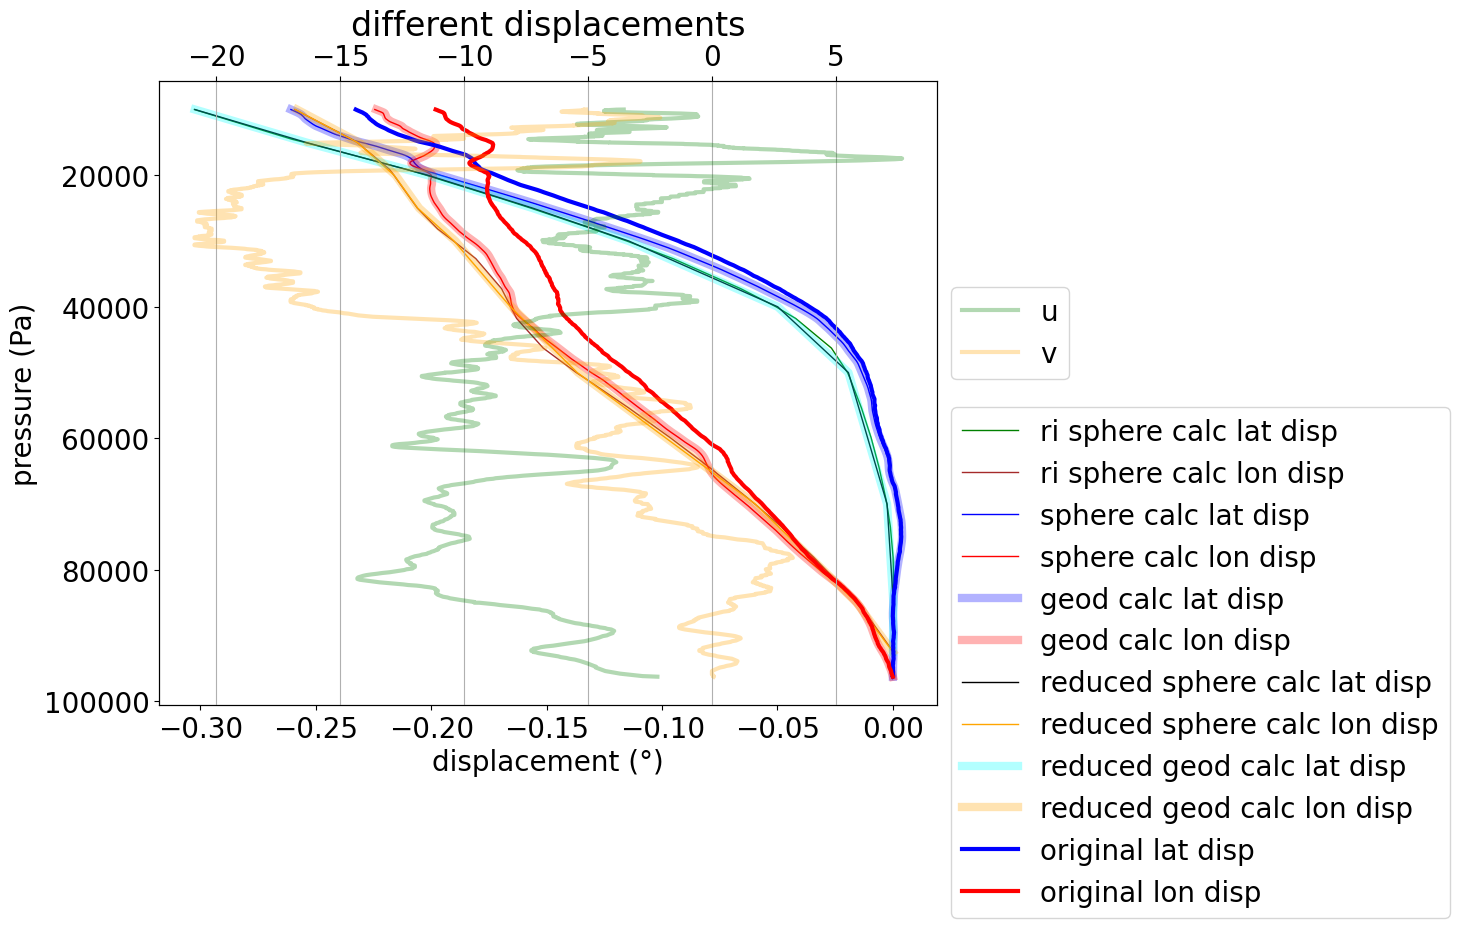

length of input data: 1744
significant levels: 11


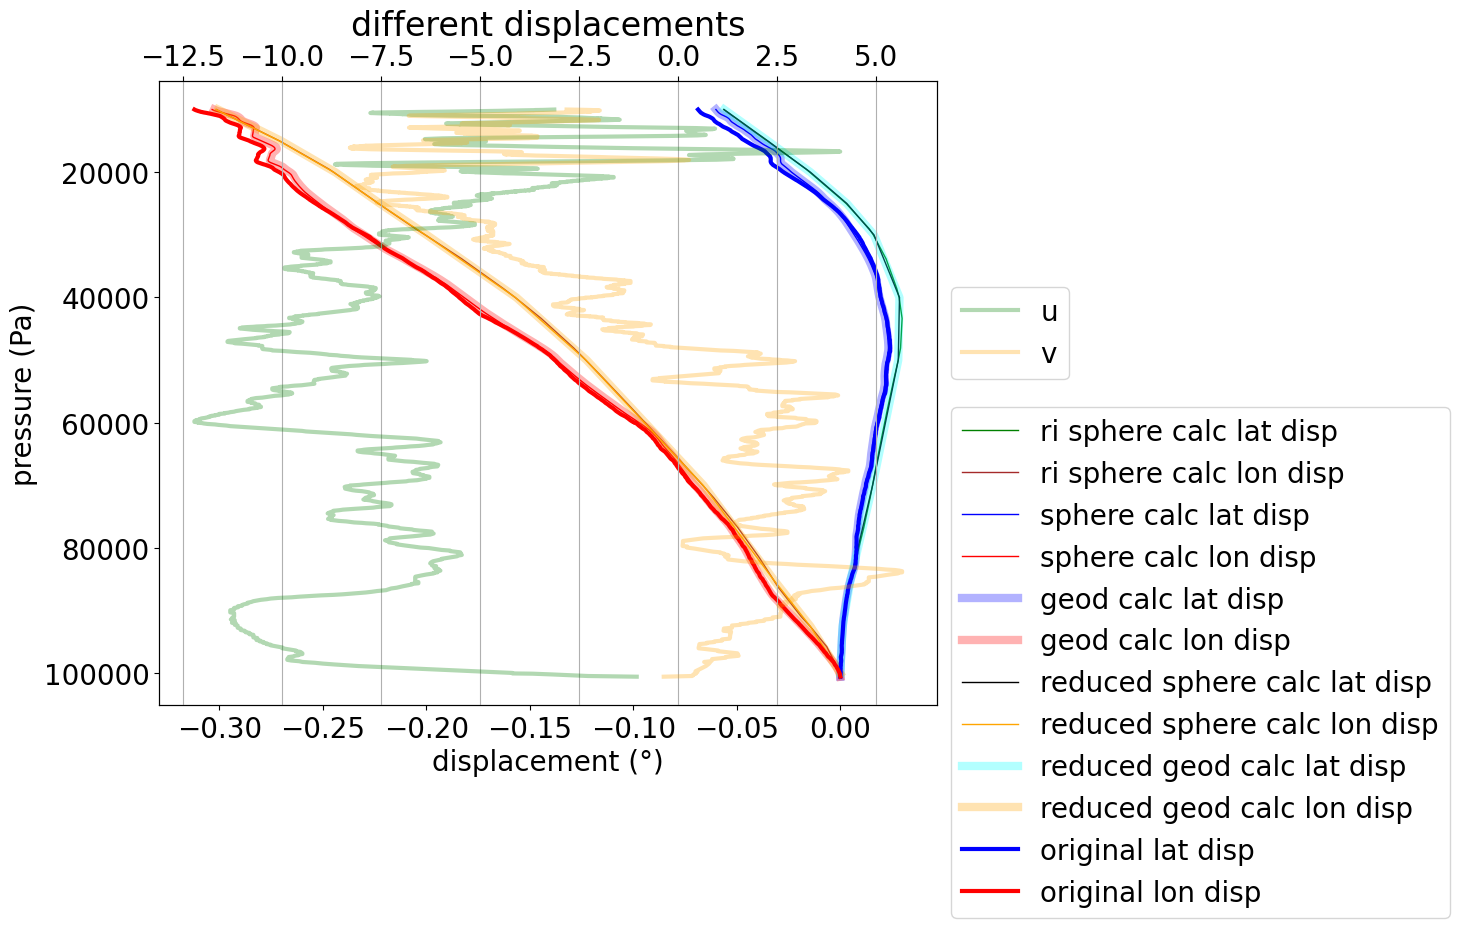

length of input data: 1332
significant levels: 13


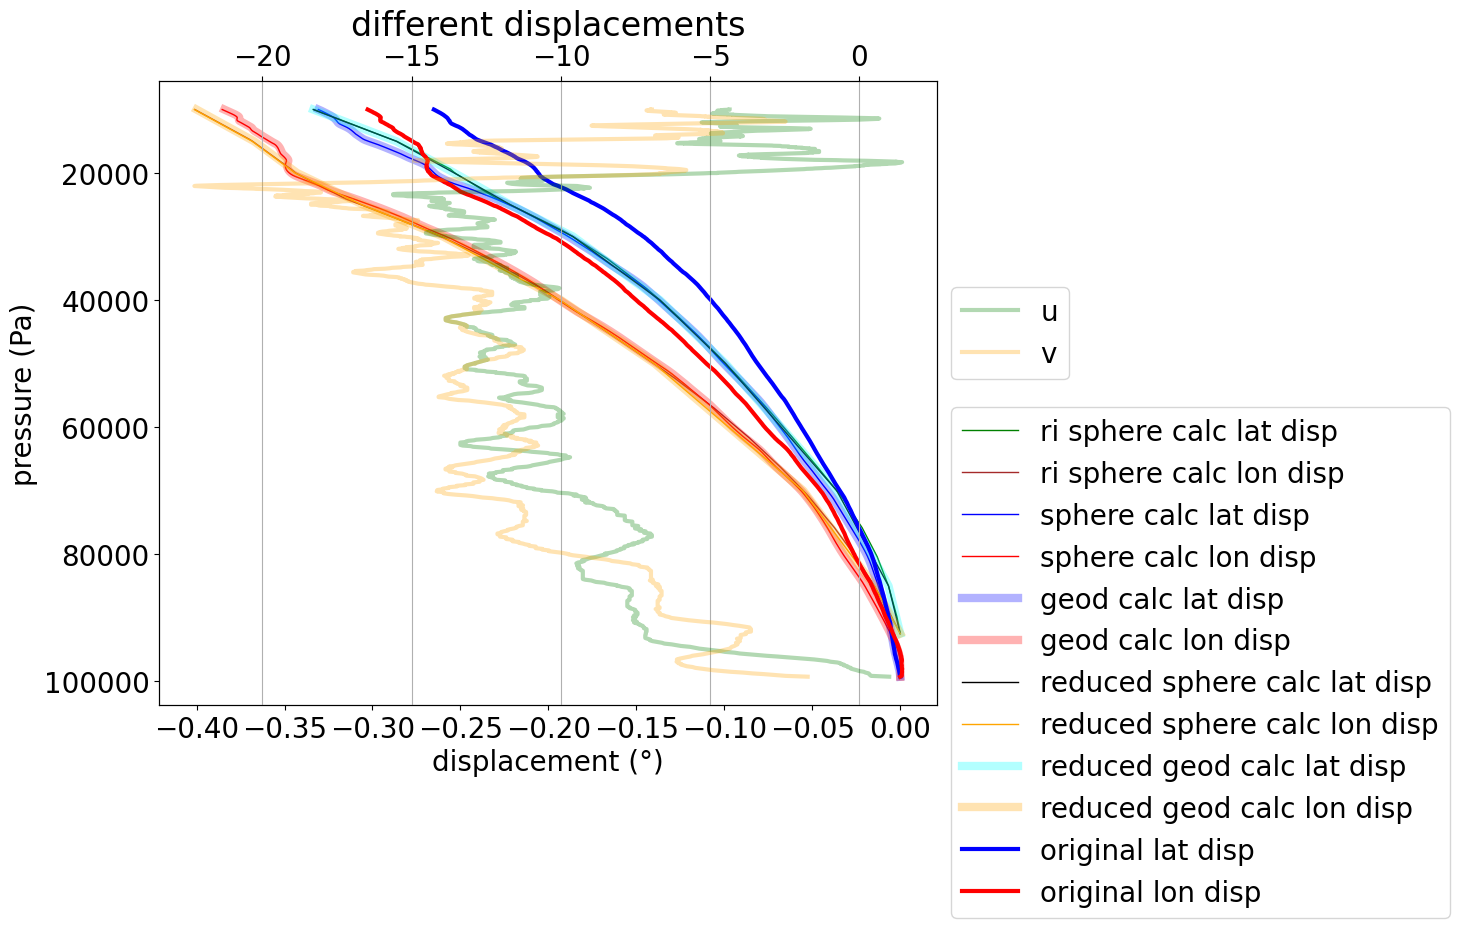

length of input data: 3357
significant levels: 8


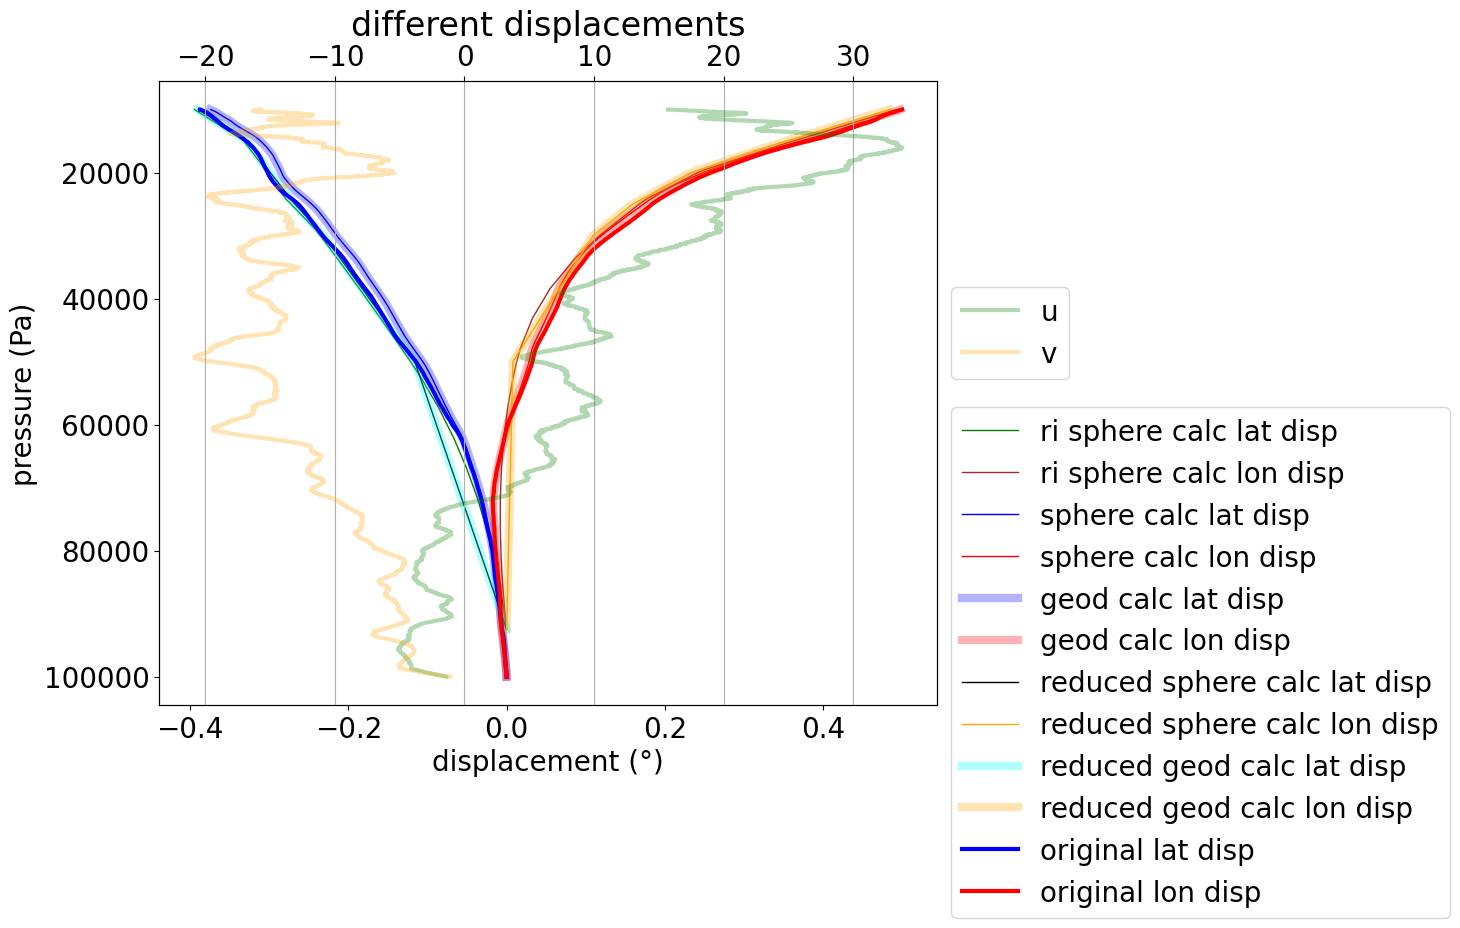

length of input data: 3330
significant levels: 7


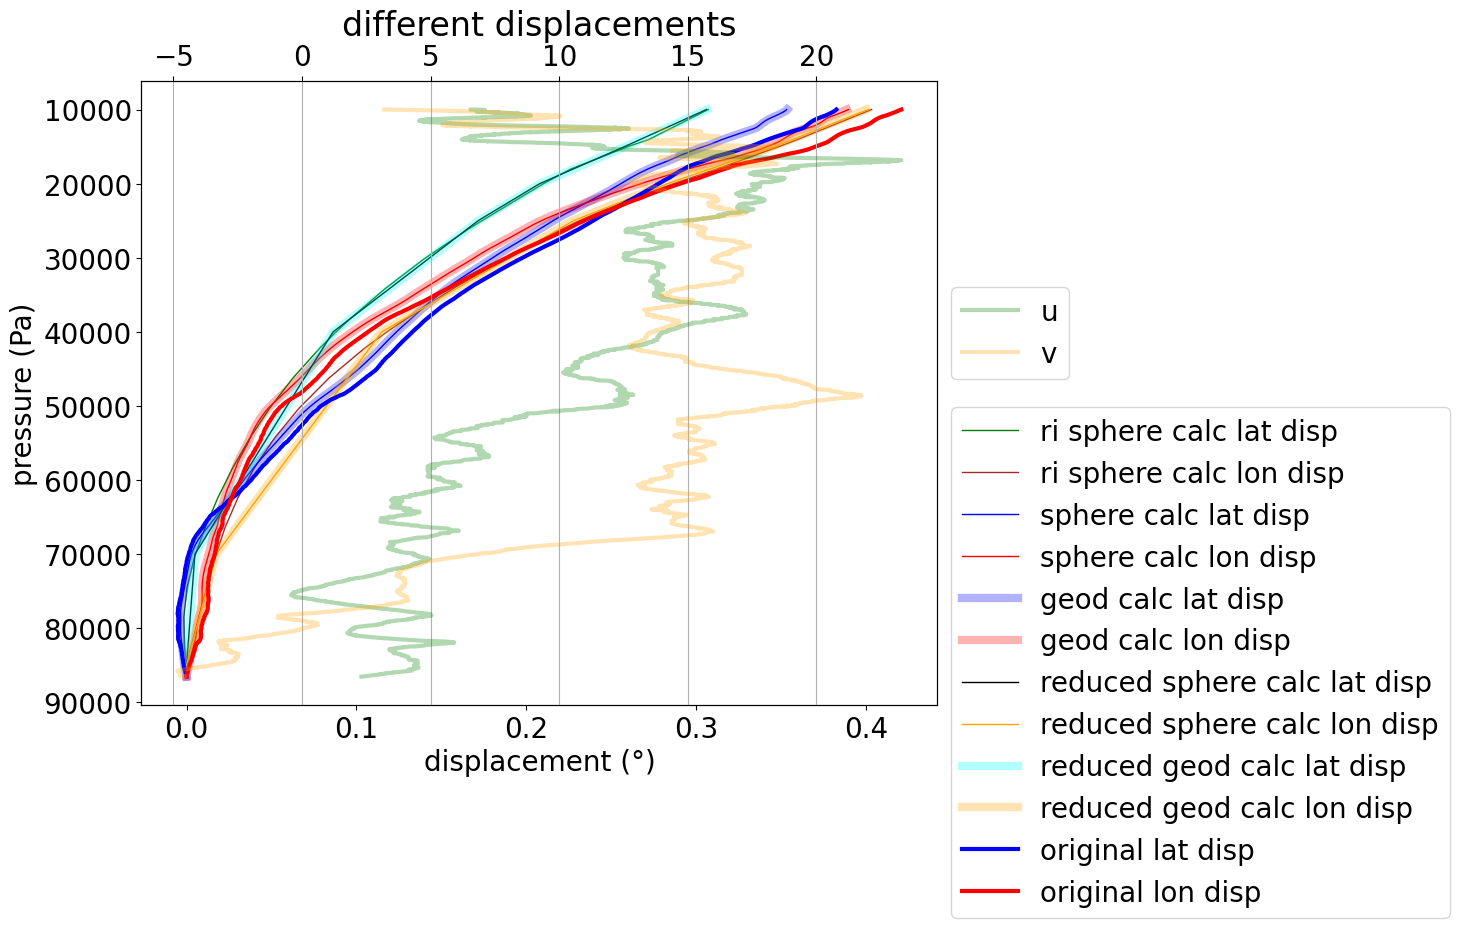

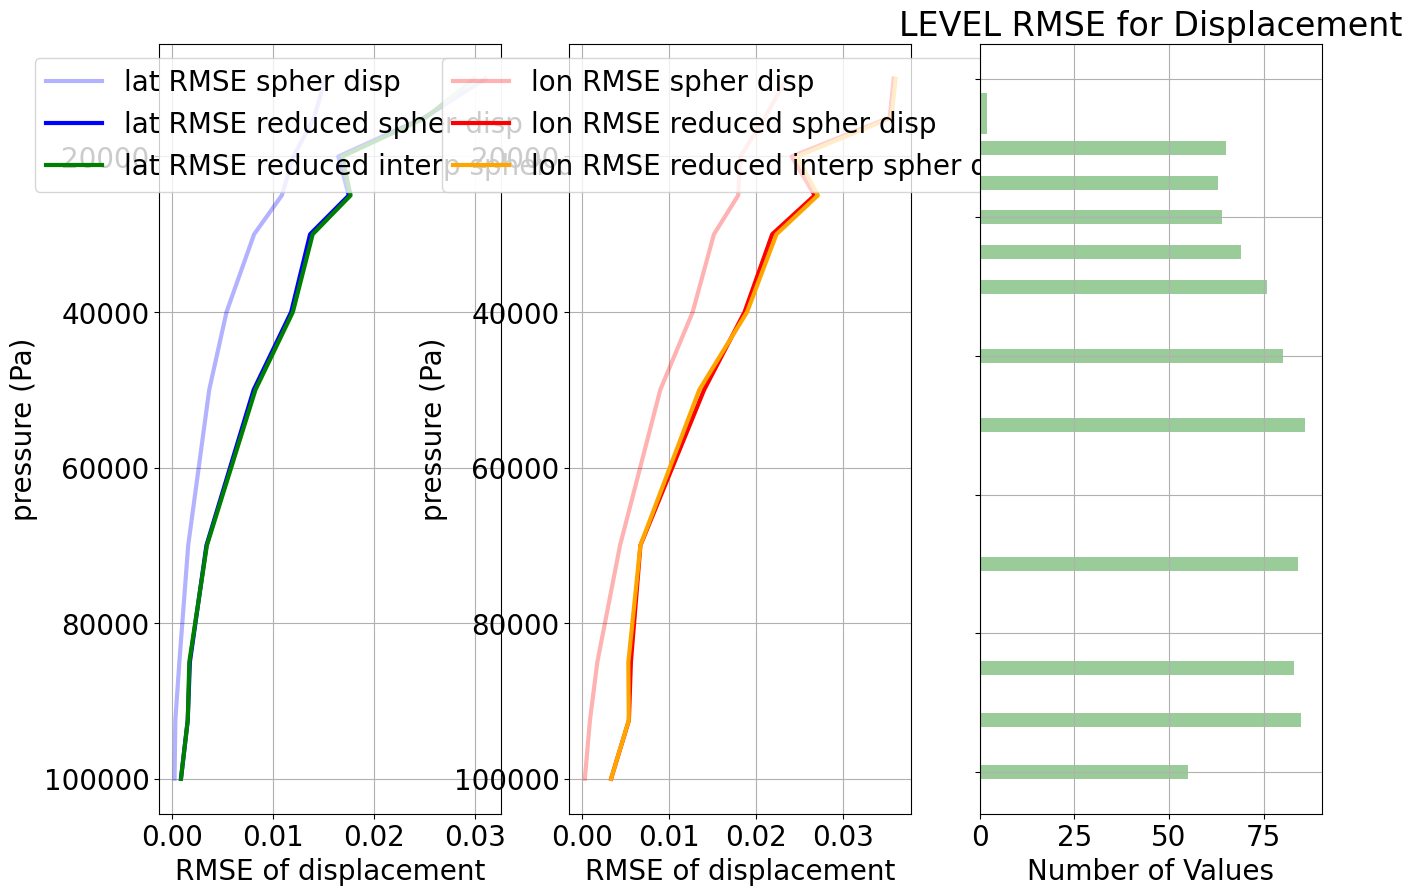

In [9]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_rmse_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [13]:
def par_read_bufr_stn_nofeedback_mre_interp(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}
    rmse_sum_lon_sri={}
    rmse_sum_lat_sri={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []
        rmse_sum_lon_sri[i] = []
        rmse_sum_lat_sri[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            if len(reduced_out) < 5:
                continue
                
            if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
                continue
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue
                
            num_p = 20
            p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
            true_p_list = list(reduced_out.pressure)
            for i in p_list:
                true_p_list.append(find_nearest(out.pressure, i))
            interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
            # display(interpolated_reduced_out)
            # display(reduced_out)
            u_new = []
            v_new = []
            # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
            # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
            # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
            # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
            for k in range(len(interpolated_reduced_out)):
                if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
                    u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
                    v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
                else:
                    u_new.append(np.nan)
                    v_new.append(np.nan)

            u = np.array(u_new)
            v = np.array(v_new)
            interpolated_reduced_out['ip_u'] = u
            interpolated_reduced_out['ip_v'] = v
            interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
            reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
                pressure=np.array(interpolated_reduced_out.pressure),
                transport_type='sphere')
            
            # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

            sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='sphere')

            reduced_sph_lat_disp, reduced_sph_lon_disp, dummy, dummy, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='sphere')

            ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='geod')

            reduced_ell_lat_disp, reduced_ell_lon_disp, dummy, dummy, reduced_ell_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='geod')
            

            for i in stdplevs:
                try:
                    rmse_sum_lon_s[i].append(
                        float(np.abs(np.array(sph_lon_disp)[out.pressure == i] - 
                              out[out.pressure == i].longitudeDisplacement.values)
                        / (np.abs(out[out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_s[i].append(
                        float(np.abs(np.array(sph_lat_disp)[out.pressure == i] - 
                              out[out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(out[out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lon_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lat_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    rmse_sum_lon_sr[i].append(np.nan)
                    rmse_sum_lat_sr[i].append(np.nan)
                    rmse_sum_lon_sri[i].append(np.nan)
                    rmse_sum_lat_sri[i].append(np.nan)
                    plev_vals[i].append(0)
                    
            if (pltcount % 20) == 0:
                print('length of input data:',len(out))
                print('significant levels:',len(reduced_out))
                # display(interpolated_reduced_out)
                fig, ax1 = maplt.subplots(figsize=(15, 9))
                ax1.plot(np.array(reduced_interp_sph_lat_disp), interpolated_reduced_out.pressure, color = 'green', alpha = 1, linewidth= 1, label='ri sphere calc lat disp')
                ax1.plot(np.array(reduced_interp_sph_lon_disp), interpolated_reduced_out.pressure, color = 'brown', alpha = 1, linewidth= 1, label='ri sphere calc lon disp')

                ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
                ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')

                ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
                ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

                ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
                ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')

                ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
                ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

                #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
                #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
                ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

                ax1.set_ylabel('pressure (Pa)')
                ax1.set_xlabel('displacement (°)')
                ax1.tick_params(axis='x')
                ax1.set_ylim(ax1.get_ylim()[::-1])
                ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

                ax1_2 = ax1.twiny()
                ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
                ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('different displacements')
                maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
                maplt.grid()
                maplt.show()
                maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            # break
            if pltcount > 100:
                break
    
    limit = [5,95]
    for i in stdplevs:
        
        rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
        rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
        rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
        rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        rmse_sum_lat_sri[i] = np.array(rmse_sum_lat_sri[i])
        rmse_sum_lon_sri[i] = np.array(rmse_sum_lon_sri[i])
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sri[i], limit)
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sri[i], limit)
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] > outlier_drop[1]] = np.nan
    
    rmse_lat_s = []
    rmse_lon_s = []
    rmse_lat_sr = []
    rmse_lon_sr = []
    rmse_lat_sri = []
    rmse_lon_sri = []
    for i in stdplevs:
        # rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
        # rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
        # rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
        # rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        # rmse_lat_sri.append(np.sqrt(np.nanmean((rmse_sum_lat_sri[i])**2)))
        # rmse_lon_sri.append(np.sqrt(np.nanmean((rmse_sum_lon_sri[i])**2)))
        
        rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
        rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
        rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
        rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        rmse_lat_sri.append(np.nanmean(rmse_sum_lat_sri[i]))
        rmse_lon_sri.append(np.nanmean(rmse_sum_lon_sri[i]))

    
    fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
    ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat MRE spher disp')
    ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat MRE reduced spher disp')
    ax1[0].plot(np.array(rmse_lat_sri), stdplevs, color = 'green', label = 'lat MRE interp reduced spher disp')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('Mean relative error of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    
    ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon MRE spher disp')
    ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon MRE reduced spher disp')
    ax1[1].plot(np.array(rmse_lon_sri), stdplevs, color = 'orange', label = 'lon MRE interp reduced spher disp')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('Mean relative error of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    value_nr = []
    for i in plev_vals:
        value_nr.append(np.sum(plev_vals[i]))
    ax1[2].barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
    ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    ax1[2].set_xlabel('Number of Values')
    ax1[2].tick_params(labelleft=False)
    ax1[2].grid()
    
    maplt.title('LEVEL MRE for Displacement')
    maplt.show()
    maplt.close()
    
    return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>
length of input data: 931
significant levels: 5


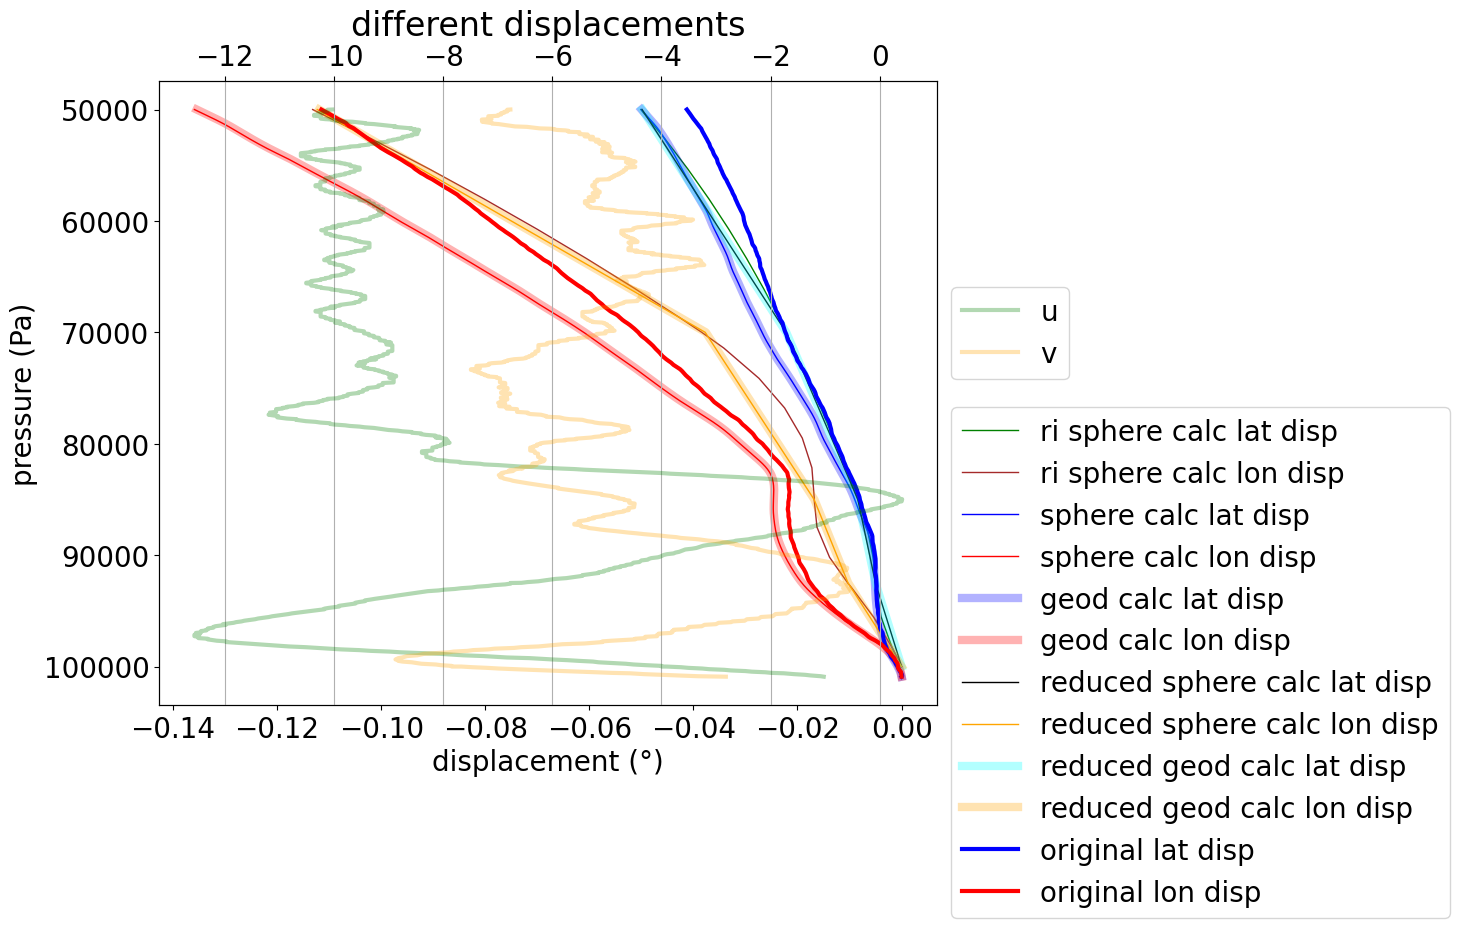

length of input data: 1440
significant levels: 10


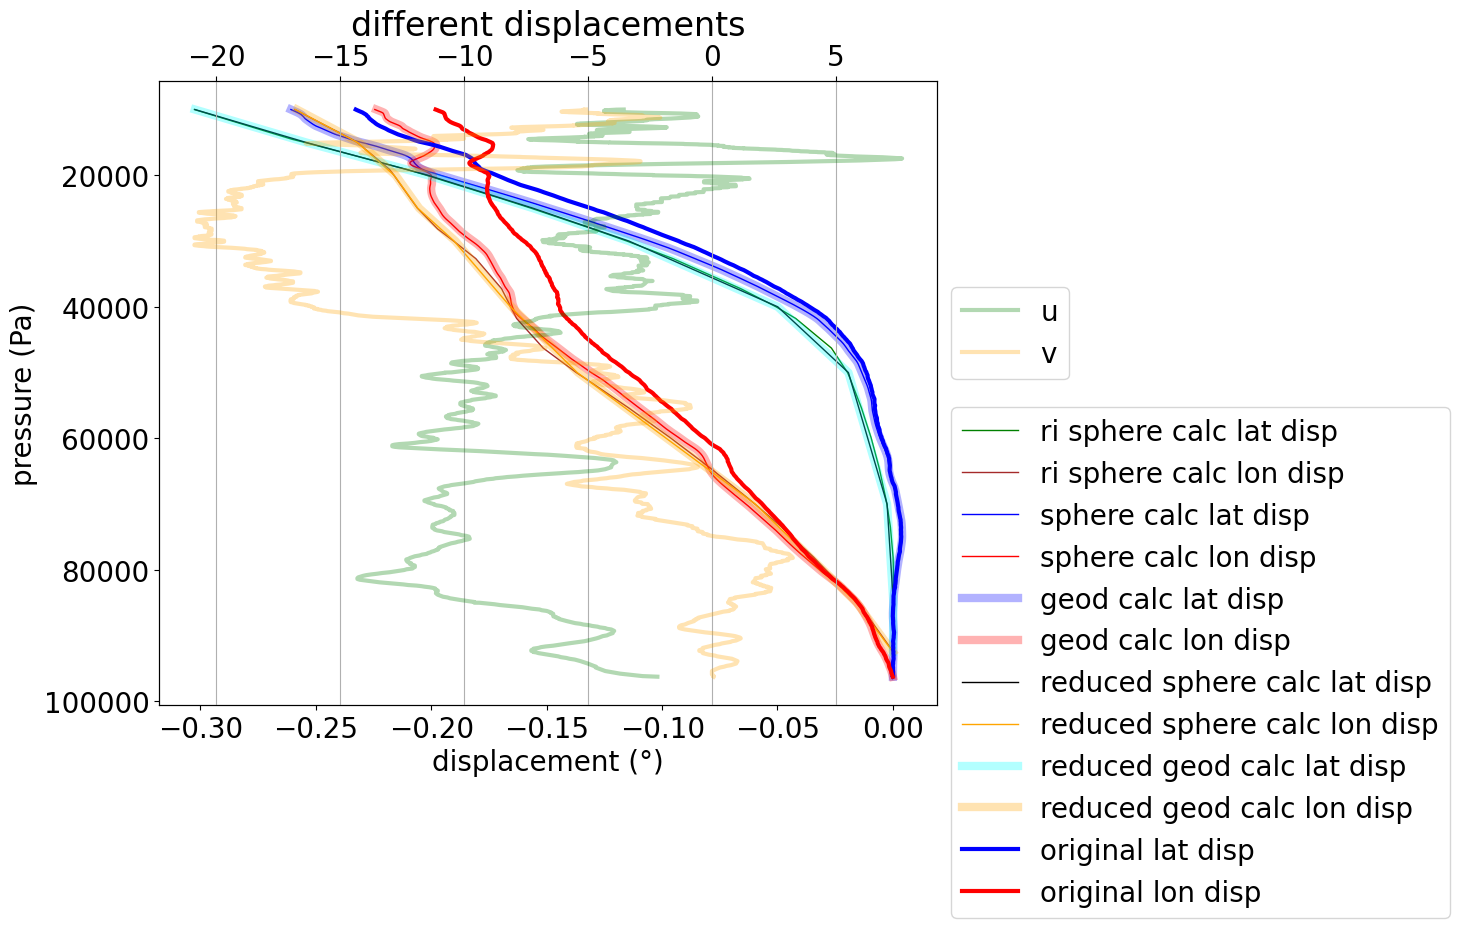

length of input data: 1744
significant levels: 11


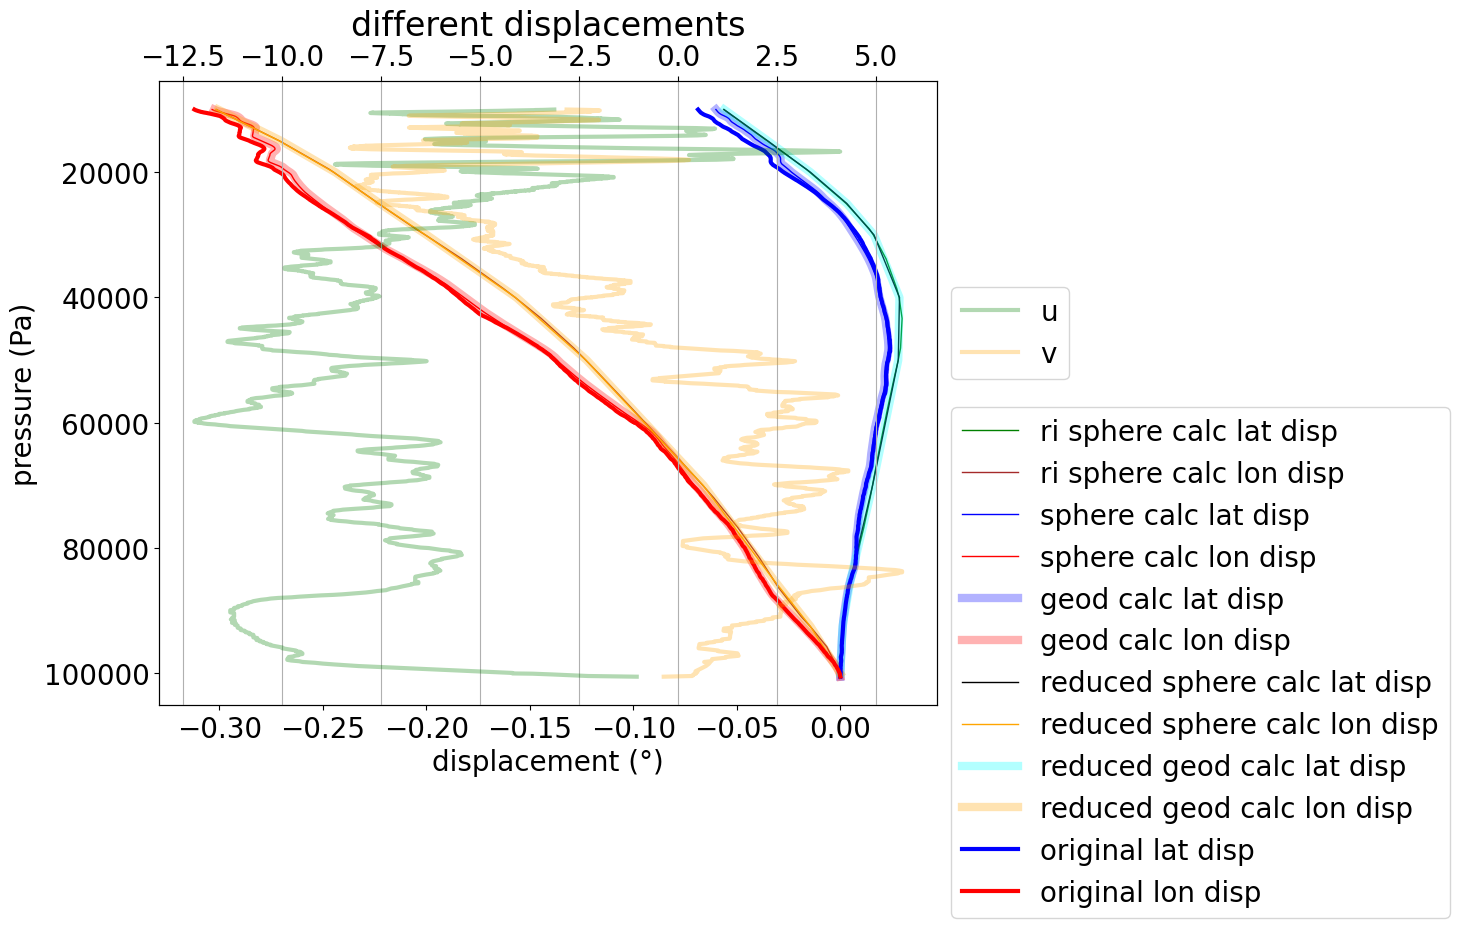

length of input data: 1332
significant levels: 13


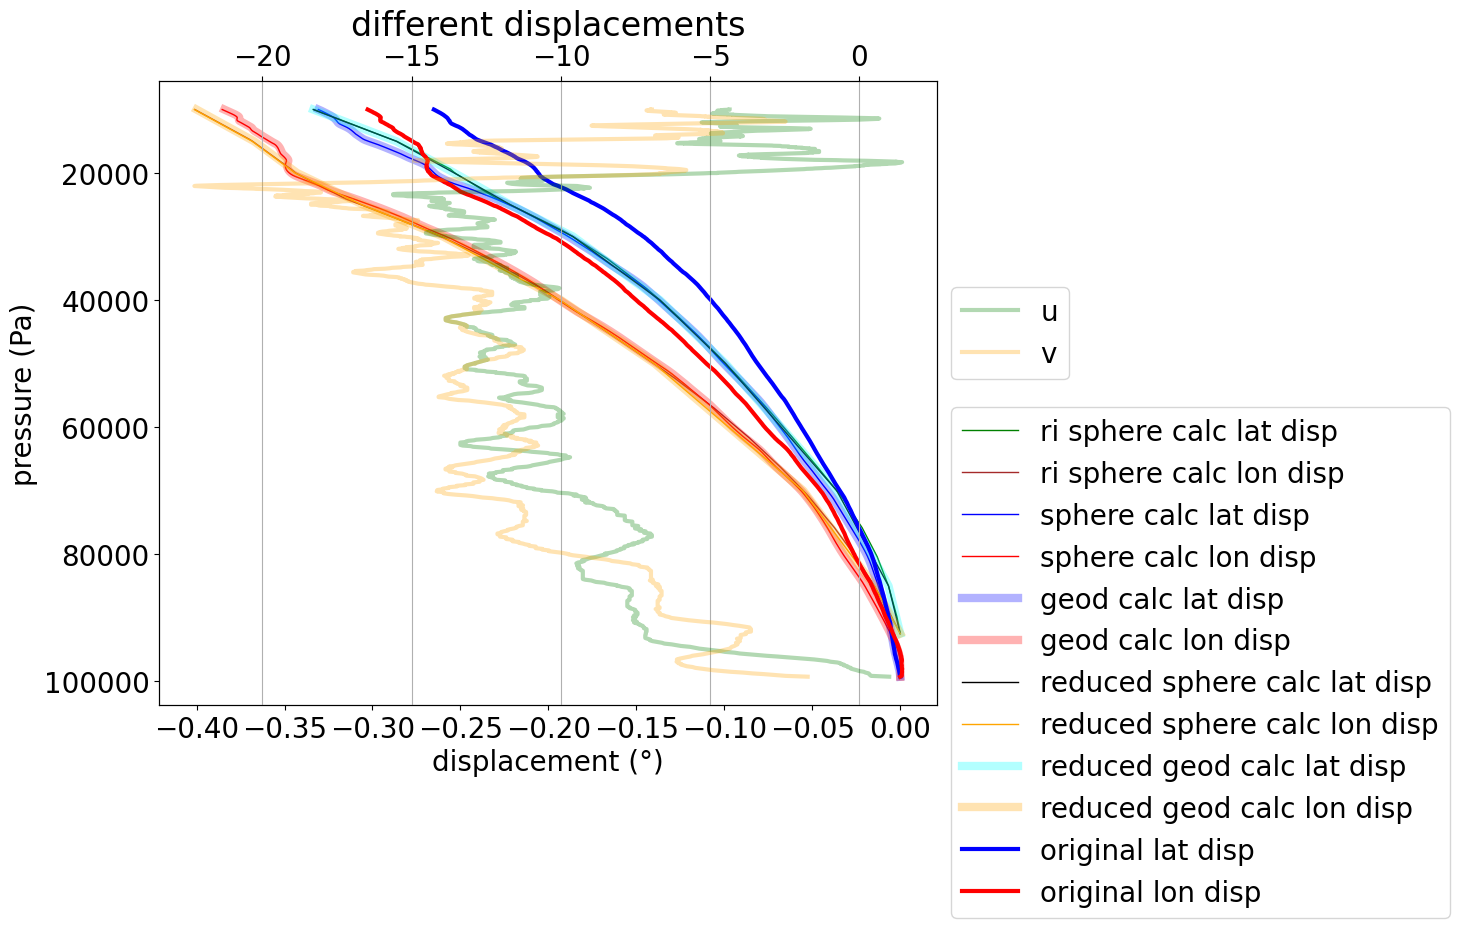

length of input data: 3357
significant levels: 8


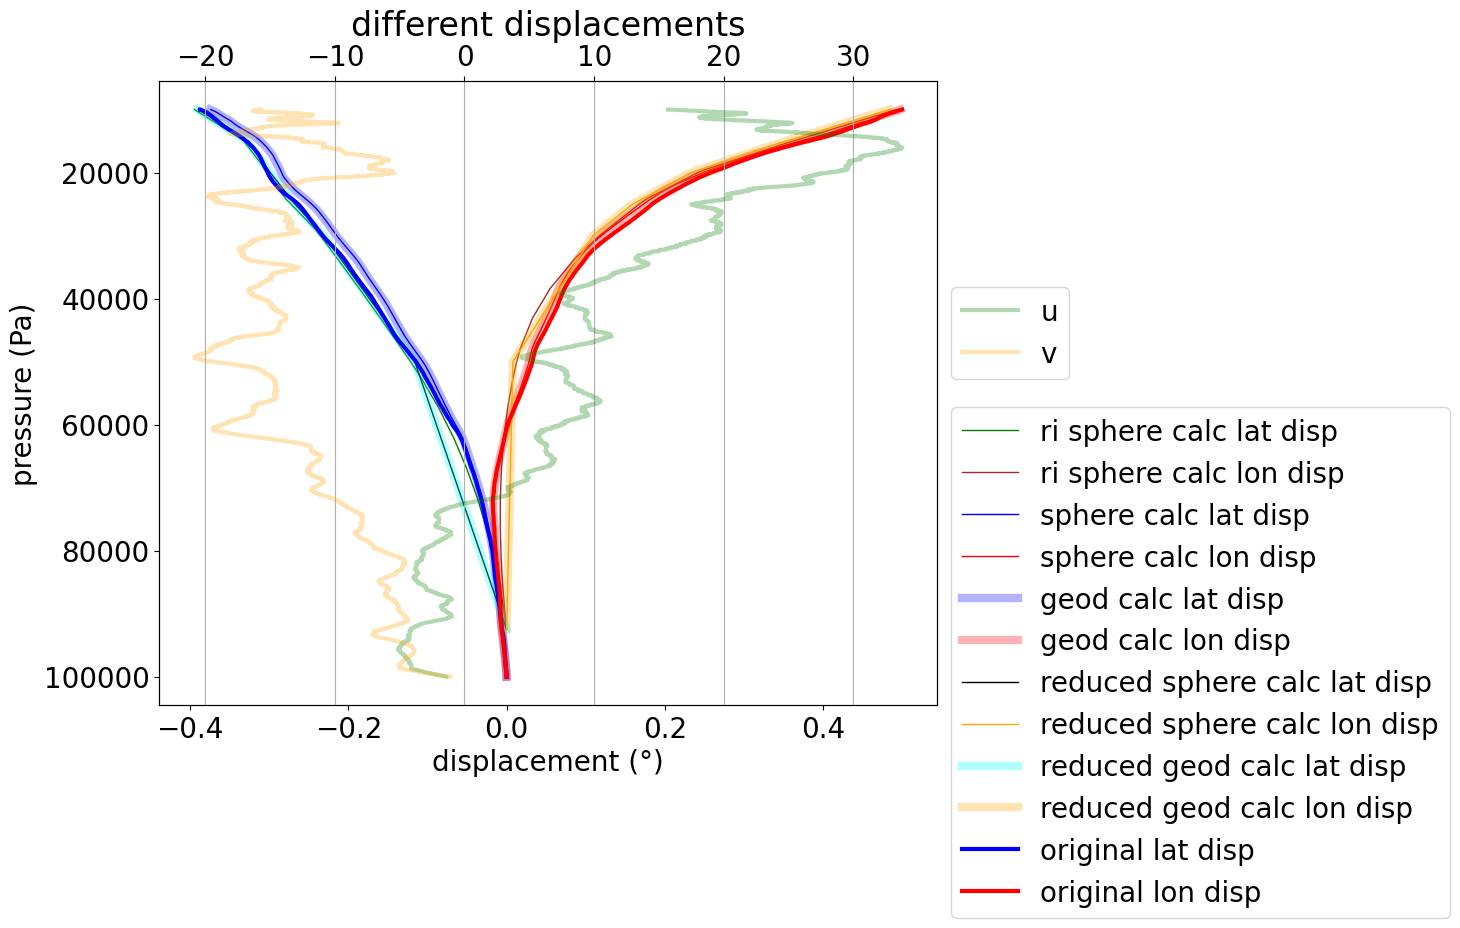

length of input data: 3330
significant levels: 7


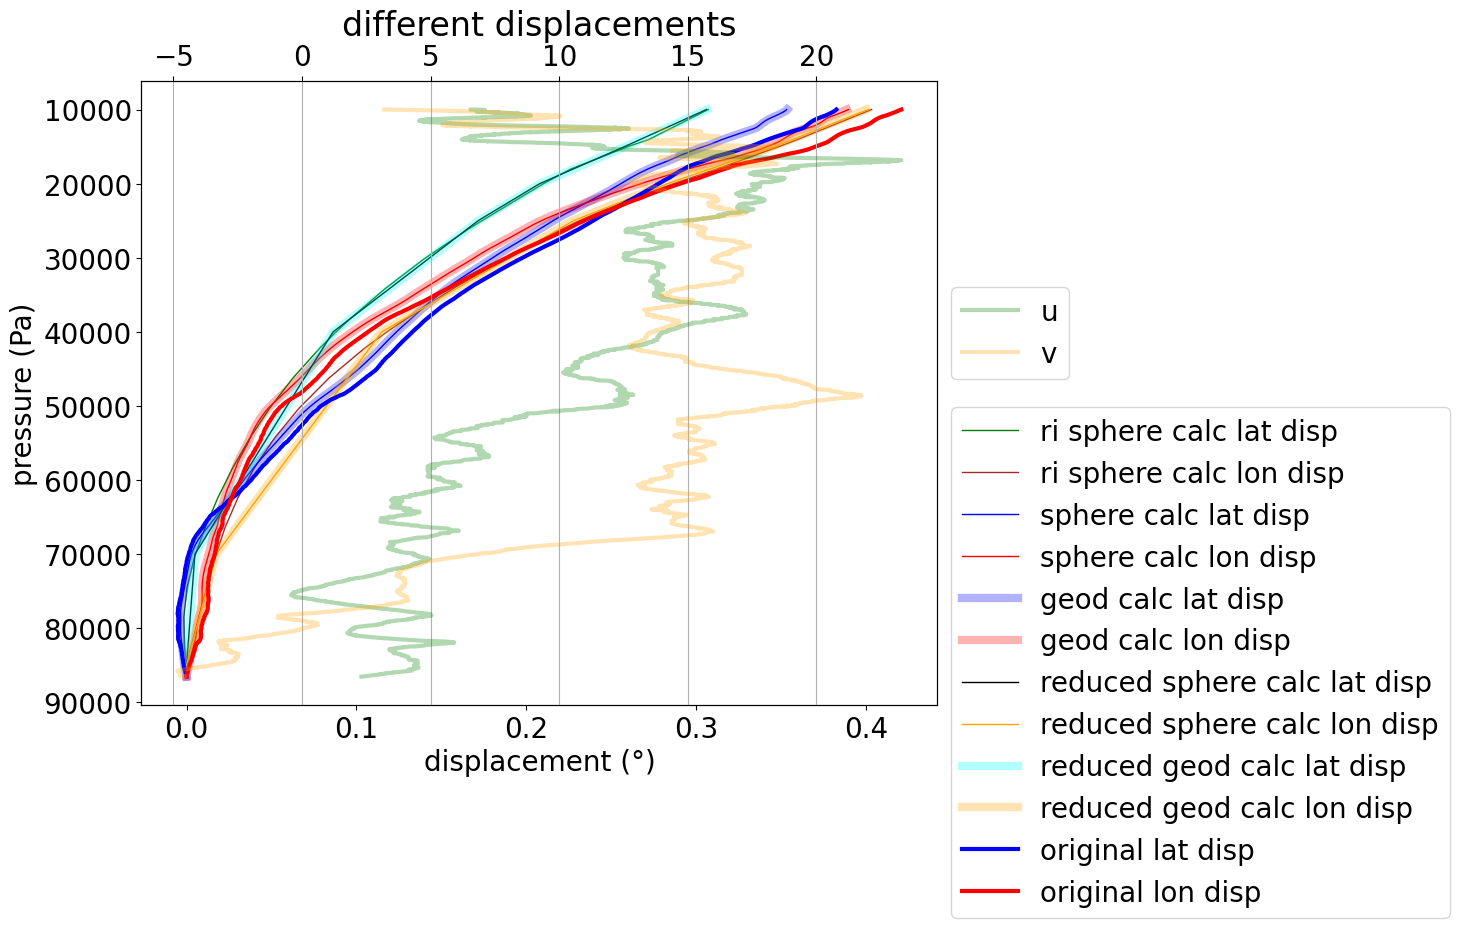

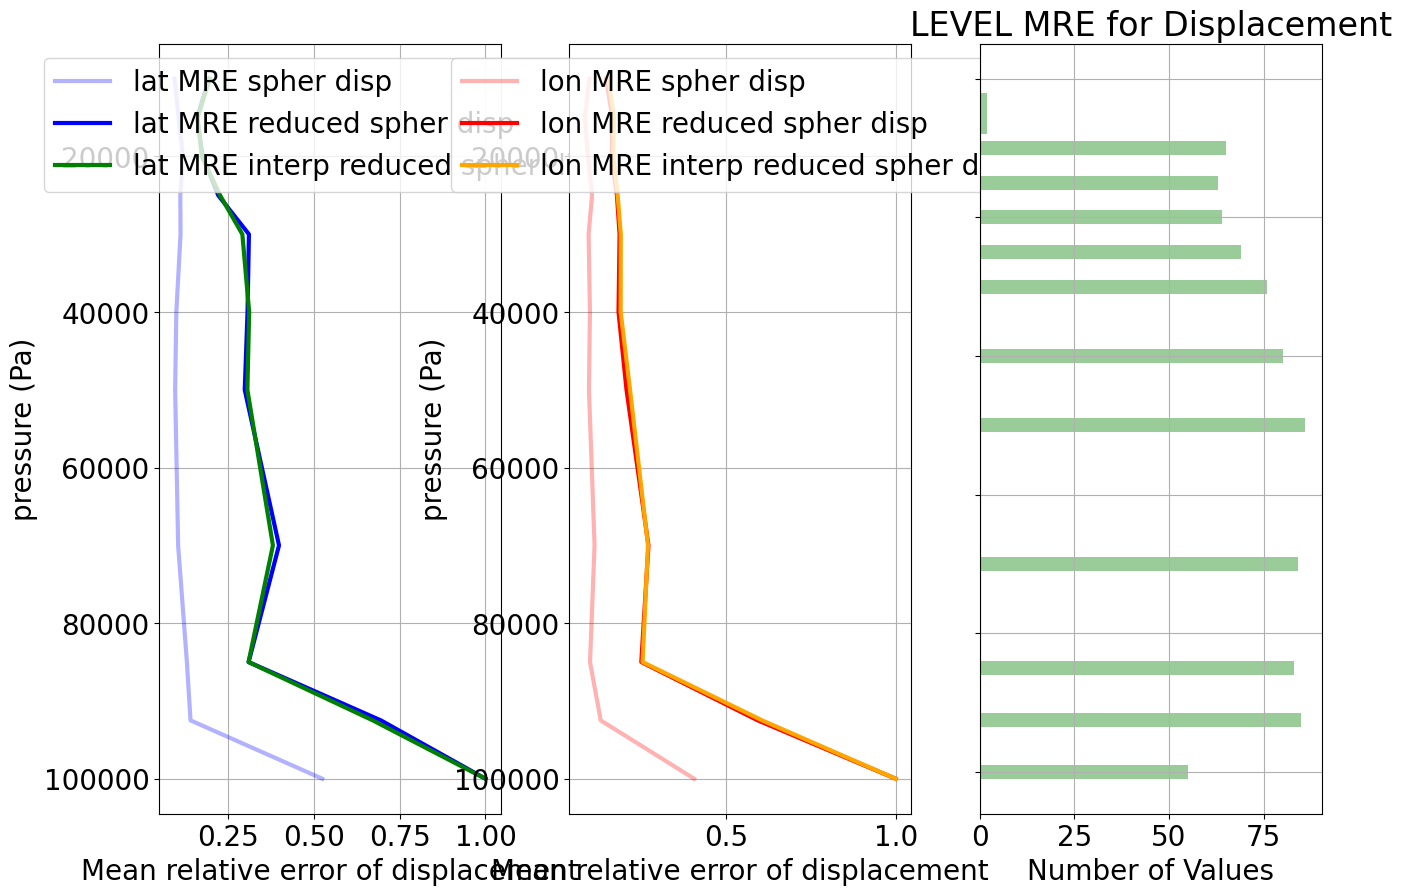

In [14]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])
